# Import Dependencies

In [1]:
#Data Gathering/Transforming/Cleaning
import pandas as pd
import numpy as np

#Analysis
import functools as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as shc

#Visualisations
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px

#Modelling GAN
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers import LeakyReLU
import tensorflow as tf
from sklearn import metrics
from sklearn import svm
import pickle

#Modelling SOM
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import animation, colors

# Functions

In [2]:
#Define functions

#Calls the tables from the URLs
def create_dfs(league):
    url_call = pd.read_html(league)
    dfs = {
        'season' : url_call[0],
        'squad stats' : url_call[2],
        'gk' : url_call[4],
        'adv gk' : url_call[6],
        'shooting' : url_call[8],
        'passing' : url_call[10],
        'pass types' : url_call[12],
        'goal & sca' : url_call[14],
        'defence' : url_call[16],
        'possession' : url_call[18],
        'play time' : url_call[20],
        'misc' : url_call[22]
        }
    return dfs

#extends a list based on the year called and inserts the data into the list
def year_df(year):
    season_list = []
    squad_list = []
    gk_list = []
    adv_gk_list = []
    shooting_list = []
    passing_list = []
    pass_types_list = []
    goal_sca_list = []
    defence_list = []
    possession_list = []
    play_time_list = []
    misc_list = []
    
    for item in year:
        league = create_dfs(item)
        season_list.extend([league['season']])
        squad_list.extend([league['squad stats']])
        gk_list.extend([league['gk']])
        adv_gk_list.extend([league['adv gk']])
        shooting_list.extend([league['shooting']])
        passing_list.extend([league['passing']])
        pass_types_list.extend([league['pass types']])
        goal_sca_list.extend([league['goal & sca']])
        defence_list.extend([league['defence']])
        possession_list.extend([league['possession']])
        play_time_list.extend([league['play time']])
        misc_list.extend([league['misc']])
        
    full_list = (season_list,
    squad_list,
    gk_list,
    adv_gk_list,
    shooting_list,
    passing_list,
    pass_types_list,
    goal_sca_list,
    defence_list,
    possession_list,
    play_time_list,
    misc_list)
        
    return full_list

#removes messy overhead columns that group variables together
def clean_cols(df):
    orig_cols = df.columns
    new_cols = []
    for x,y in orig_cols:
        if x == 'Home':
            y = f'Home_{y}'
        if x == 'Away':
            y = f'Away_{y}'

        new_cols.append(y)
    df.columns = new_cols
    return df

#concatenate tables together to form a dataframe for each season
def df_construct(table):
    season_df = pd.concat(table[0], ignore_index = True)
    squad_df = pd.concat(table[1], ignore_index = True)
    gk_df = pd.concat(table[2], ignore_index = True)
    adv_gk_df = pd.concat(table[3], ignore_index = True)
    shooting_df = pd.concat(table[4], ignore_index = True)
    passing_df = pd.concat(table[5], ignore_index = True)
    pass_types_df = pd.concat(table[6], ignore_index = True)
    goal_sca_df = pd.concat(table[7], ignore_index = True)
    defence_df = pd.concat(table[8], ignore_index = True)
    possession_df = pd.concat(table[9], ignore_index = True)
    play_time_df = pd.concat(table[10], ignore_index = True)
    misc_df = pd.concat(table[11], ignore_index = True)
    
    all_df = [season_df,
              squad_df,
              gk_df,
              adv_gk_df,
              shooting_df,
              passing_df,
              pass_types_df,
              goal_sca_df,
              defence_df,
              possession_df,
              play_time_df,
              misc_df]
    
    return all_df

#cleans the columns from the tables
def clean_df(df):
    
    table_list = [df[1],
                 df[2],
                 df[3],
                 df[4],
                 df[5],
                 df[6],
                 df[7],
                 df[8],
                 df[9],
                 df[10],
                 df[11]]
    for i in table_list:
        clean_cols(i)
        
    table_list.append(df[0])
    return table_list

#appends a year variable to the dataframe called
def year_col(df, year):
    df['Year'] = np.where(df['Squad'], year, '')
    return df

#appends a league column to the dataframe called
def league_col(df):
    df.loc[0:19, 'League'] = 'Premier League'
    df.loc[20:39, 'League'] = 'La Liga'
    df.loc[40:59, 'League'] = 'Serie A'
    df.loc[60:79, 'League'] = 'Ligue 1'
    df.loc[80:97, 'League'] = 'Bundesliga'
    return df

#when concatenating the tables into dataframes, some columns became messy and unorganised or duplicated
#this function cleans up the columns, renames, and relocates the columns properly
def cmp_col(df):
    if len(df.columns) == 250:
            df.columns=['Squad',
                        '# of Players Used',
                        'Avg. Age', 
                        'Avg. Possession', 
                        'Matches Played', 
                        'Starts', 
                        'Minutes Played',
                        '90s Played',
                        'Goals For',
                        'Assists', 
                        'NP Goals',
                        'PK Scored', 
                        'PK Attempted',
                        'Yellow Cards',
                        'Red Cards',
                        'Goals per 90',
                        'Assists per 90',
                        'Goals + Assists per 90',
                        'NP Goals per 90',
                        'NP Goals + Assists per 90',
                        'Expected Goals',
                        'NP Expected Goals',
                        'Expected Assisted Goals',
                        'Expected NP Goals + Assists',
                        'Expected Goals per 90',
                        'Expected Assisted Goals per 90',
                        'Expected Goals + Assists per 90',
                        'Expected NP Goals per 90',
                        'Expected NP Goals + Assists per 90',
                        '# of GK Used',
                        '# of Minutes Played',
                        'Starts GK',
                        'GK Mins Played',
                        'GK 90s played',
                        'Goals Against',
                        'Goals Against per 90',
                        'Shots on Target Against',
                        'Saves Made',
                        'Save Percentage',
                        'Wins1',
                        'Draws1',
                        'Losses1',
                        'Clean Sheets',
                        'Clean Sheets %',
                        'PK Allowed',
                        'PK Scored Against',
                        'PK Saved',
                        'PK Opposition Missed',
                        'PK Save Percentage',
                        'No GK Used',
                        'GK 90s Play',
                        'Goals Against',
                        'Penalty Kicks Against',
                        'Free Kicks Goals Against',
                        'Corner Kicks Goals Against',
                        'Own Goals Conceded',
                        'GK Post-Shot Expected Goals',
                        'GK Post-Shot Expected Goals per Shot on Target',
                        'GK Post-Shot Expected Goals Minus Goals Allowed',
                        'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
                        'GK Passes Completed > 40 yards',
                        'GK Passes Attempted > 40 yards',
                        'GK Pass Completion Percentage > 40 yards',
                        'GK Passes Attempted (No Goal Kicks)',
                        'GK Throws Attempted',
                        'GK % of Passes > 40 yards (No Goal Kicks)',
                        'GK Avg. Length of Passes',
                        'GK Goal Kicks Attempted',
                        'GK % of Goal Kicks > 40 yards',
                        'GK Avg. Length of Goal Kicks',
                        'Opposition Attempted Crosses',
                        '# of Crosses Claimed',
                        '% of Crosses Claimed',
                        'GK # of Def. Actions Outside Box',
                        'GK # of Def. Actions Outside Box per 90',
                        'GK Avg. Distance from Goal of Def. Actions',
                        'No of Players Used in Game',
                        'Minutes Played / 90',
                        'All Goals Scored',
                        'Total Shots',
                        'Shots on Target',
                        '% of Shots on Target',
                        'Total Shots per 90',
                        'Shots on Target per 90',
                        'Goals per Shot',
                        'Goals per Shot on Target',
                        'Avg. Distance from Goal Shooting',
                        'Free Kick Shots',
                        'Penalty Kick Shots',
                        'Penalty Kicks Attempted To Score',
                        'Expected Goals',
                        'Non Penalty Expected Goals',
                        'NP Expected Goals per Shot',
                        'Goals Minus Expected Goals',
                        'NP Goals Minus Expected Goals',
                        'No of Players Passing',
                        '90s Played Passes More',
                        'Total Passes Completed',
                        'Total Passes Attempted',
                        '% of Total Passes Completed',
                        'Total Distance of Passes',
                        'Progressive Distance of Passes',
                        'Short Passes Completed',
                        'Short Passes Attempted',
                        '% of Short Passes Completed',
                        'Medium Passes Completed',
                        'Medium Passes Attempted',
                        '% of Medium Passes Completed',
                        'Long Passes Completed',
                        'Long Passes Attempted',
                        '% of Long Passes Completed',
                        'Assists',
                        'Expected Assisted Goals',
                        'Expected Assists',
                        'Assists Minus Expected Goals Assisted',
                        'Key Passes (directly lead to shot)',
                        'Completed Passes into Final Third',
                        'Completed Passes into Box',
                        'Completed Crosses into Box',
                        'Progressive Passes',
                        'Players Used in Game Passing More',
                        '90s Played Passes Passes',
                        'Total Passes Attempted Pass',
                        'Live Ball Passes',
                        'Dead Ball Passes',
                        'Passes Attempted from Free Kicks',
                        'Passes Completed by Defenders into Open Space',
                        'Switches > width of 40 yards',
                        'Crosses',
                        'Throw-Ins',
                        'Corner Kicks',
                        'Inswinging Corners',
                        'Outswinging Corners',
                        'Straight Corners',
                        'Total Passes Completed Again',
                        'Offsides',
                        'Passes Blocked by Opposition',
                        'Players Used SCA',
                        'Players Used SCA / 90',
                        'Shot Creating Actions',
                        'Shot Creating Actions per 90',
                        'Live Ball Passes Leading to Shot',
                        'Dead Ball Passes Leading to Shot',
                        'Dribbles Leading to Shot',
                        'Shot Leading to Another Shot',
                        'Fouls Drawn Leading to Shot',
                        'Def. Actions Leading to Shot',
                        'Goal Creating Actions',
                        'Goal Creating Actions per 90',
                        'Live Ball Passes Leading to Goal',
                        'Dead Ball Passes Leading to Goal',
                        'Dribbles Leading to Goal',
                        'Shot Leading to Goal-Scoring Shot',
                        'Fouls Drawn Leading to Goal',
                        'Def. Actions Leading to Goal',
                        'Players Used Defence',
                        'Players Used Defence / 90',
                        '# of Players Tackled',
                        'Tackles Leading to Possession',
                        'Tackles in Def. Third',
                        'Tackles in Mid. Third',
                        'Tackles in Att. Third',
                        '# of Dribblers Tackled',
                        '# of Times Dribbled Past + Tackles',
                        '% of Dribblers Tackled',
                        '# of Times Dribbled Past',
                        '# of Blocks',
                        '# of Shots Blocked',
                        '# of Passes Blocked',
                        'Interceptions',
                        'Tackles + Interceptions',
                        'Clearances',
                        'Errors Leading to Opposing Shot',
                        'Number of Players Used Poss',
                        'Avg. Possession Poss',
                        'No. of Players Used Poss / 90',
                        'Touches',
                        'Touches in Own Box',
                        'Touches in Def. Third',
                        'Touches in Mid. Third',
                        'Touches in Att. Third',
                        'Touches in Opp. Box',
                        'Live Ball Touches',
                        'Successful Dribbles',
                        'Attempted Dribbles',
                        '% of Successful Dribbles',
                        'Miscontrol',
                        'Dispossessed',
                        'Passes Received',
                        'Progressive Passes Received',
                        'Number of Players Used PT',
                        'Avg. Age',
                        'Matches Played PT',
                        'Minutes Played PT',
                        'Minutes per Match Played',
                        '% of Minutes Played',
                        '90s Played PT',
                        'Starts',
                        'Avg. Minutes Starting XI per 90',
                        '# of Starting XI Completed Match',
                        '# of Subs',
                        'Avg. Minutes per Subs per 90',
                        '# of Unused Subs',
                        'Points per Match',
                        'Goals Scored by Team on Pitch',
                        'Goals Allowed by Team on Pitch',
                        'Goals For Minus Goals Against for Team on Pitch',
                        'Goals For Minus Goals Against for Team on Pitch per 90',
                        'Expected Goals by Team on Pitch',
                        'Expected Goals Allowed by Team on Pitch',
                        'Expected Goals For Minus Expected Goals Against for Team on Pitch',
                        'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
                        'Number of Matches Played Misc',
                        '90s Played Misc',
                        'Yellow Card Again',
                        'Red Card Again',
                        '2nd Yellow Card',
                        'Fouls Committed',
                        'Fouls Drawn',
                        'Offsides Misc',
                        'Total Crosses',
                        'Interceptions Misc',
                        'Tackles won Possession',
                        'PK Won',
                        'PK Conceded',
                        'Own Goals Conceded',
                        'Loose Ball Recoveries',
                        'Aerial Duels Won',
                        'Aerial Duels Lost',
                        '% of Aerial Duels Won',
                        'Table Position',
                        'Matches Played Season',
                        'Wins',
                        'Draws',
                        'Losses',
                        'Goals Scored Season',
                        'Goals Against Season',
                        'Goal Difference Season',
                        'Points',
                        'Points per Match',
                        'Expected Goals Season',
                        'Expected Goals Against Season',
                        'Expected Goal Difference Season',
                        'Expected Goal Difference Season / 90',
                        'Attendance',
                        'Top Team Scorer',
                        'Goalkeeper',
                        'Notes',
                        'Year',
                        'League']
            
    if len(df.columns) == 251:
    
        df.columns=['Squad',
                        '# of Players Used',
                        'Avg. Age', 
                        'Avg. Possession', 
                        'Matches Played', 
                        'Starts', 
                        'Minutes Played',
                        '90s Played',
                        'Goals For',
                        'Assists', 
                        'NP Goals',
                        'PK Scored', 
                        'PK Attempted',
                        'Yellow Cards',
                        'Red Cards',
                        'Goals per 90',
                        'Assists per 90',
                        'Goals + Assists per 90',
                        'NP Goals per 90',
                        'NP Goals + Assists per 90',
                        'Expected Goals',
                        'NP Expected Goals',
                        'Expected Assisted Goals',
                        'Expected NP Goals + Assists',
                        'Expected Goals per 90',
                        'Expected Assisted Goals per 90',
                        'Expected Goals + Assists per 90',
                        'Expected NP Goals per 90',
                        'Expected NP Goals + Assists per 90',
                        '# of GK Used',
                        '# of Minutes Played',
                        'Starts GK',
                        'GK Mins Played',
                        'GK 90s played',
                        'Goals Against',
                        'Goals Against per 90',
                        'Shots on Target Against',
                        'Saves Made',
                        'Save Percentage',
                        'Wins1',
                        'Draws1',
                        'Losses1',
                        'Clean Sheets',
                        'Clean Sheets %',
                        'PK Allowed',
                        'PK Scored Against',
                        'PK Saved',
                        'PK Opposition Missed',
                        'PK Save Percentage',
                        'No GK Used',
                        'GK 90s Play',
                        'Goals Against',
                        'Penalty Kicks Against',
                        'Free Kicks Goals Against',
                        'Corner Kicks Goals Against',
                        'Own Goals Conceded',
                        'GK Post-Shot Expected Goals',
                        'GK Post-Shot Expected Goals per Shot on Target',
                        'GK Post-Shot Expected Goals Minus Goals Allowed',
                        'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
                        'GK Passes Completed > 40 yards',
                        'GK Passes Attempted > 40 yards',
                        'GK Pass Completion Percentage > 40 yards',
                        'GK Passes Attempted (No Goal Kicks)',
                        'GK Throws Attempted',
                        'GK % of Passes > 40 yards (No Goal Kicks)',
                        'GK Avg. Length of Passes',
                        'GK Goal Kicks Attempted',
                        'GK % of Goal Kicks > 40 yards',
                        'GK Avg. Length of Goal Kicks',
                        'Opposition Attempted Crosses',
                        '# of Crosses Claimed',
                        '% of Crosses Claimed',
                        'GK # of Def. Actions Outside Box',
                        'GK # of Def. Actions Outside Box per 90',
                        'GK Avg. Distance from Goal of Def. Actions',
                        'No of Players Used in Game',
                        'Minutes Played / 90',
                        'All Goals Scored',
                        'Total Shots',
                        'Shots on Target',
                        '% of Shots on Target',
                        'Total Shots per 90',
                        'Shots on Target per 90',
                        'Goals per Shot',
                        'Goals per Shot on Target',
                        'Avg. Distance from Goal Shooting',
                        'Free Kick Shots',
                        'Penalty Kick Shots',
                        'Penalty Kicks Attempted To Score',
                        'Expected Goals',
                        'Non Penalty Expected Goals',
                        'NP Expected Goals per Shot',
                        'Goals Minus Expected Goals',
                        'NP Goals Minus Expected Goals',
                        'Long Passes Attempted',
                        'Long Passes Completed',
                        '% of Long Passes Completed',
                        'Medium Passes Attempted',
                        'Medium Passes Completed',
                        '% of Medium Passes Completed',
                        'Short Passes Attempted',
                        'Short Passes Completed',
                        '% of Short Passes Completed',
                        'Total Passes Attempted',
                        'Total Passes Completed NaN',
                        '% of Total Passes Completed',
                        'Progressive Distance of Passes',
                        'Total Distance of Passes',
                        'Assists',
                        'Expected Assisted Goals',
                        'Expected Assists',
                        'No of Players Passing',
                        'Assists Minus Expected Goals Assisted',
                        'Key Passes (directly lead to shot)',
                        'Completed Passes into Final Third',
                        'Completed Passes into Box',
                        'Completed Crosses into Box',
                        'Progressive Passes',
                        '90s Played Passes More',
                        'Total Passes Completed',
                        'Players Used in Game Passing More',
                        '90s Played Passes Passes',
                        'Total Passes Attempted Pass',
                        'Live Ball Passes',
                        'Dead Ball Passes',
                        'Passes Attempted from Free Kicks',
                        'Passes Completed by Defenders into Open Space',
                        'Switches > width of 40 yards',
                        'Crosses',
                        'Throw-Ins',
                        'Corner Kicks',
                        'Inswinging Corners',
                        'Outswinging Corners',
                        'Straight Corners',
                        'Total Passes Completed Again',
                        'Offsides',
                        'Passes Blocked by Opposition',
                        'Players Used SCA',
                        'Players Used SCA / 90',
                        'Shot Creating Actions',
                        'Shot Creating Actions per 90',
                        'Live Ball Passes Leading to Shot',
                        'Dead Ball Passes Leading to Shot',
                        'Dribbles Leading to Shot',
                        'Shot Leading to Another Shot',
                        'Fouls Drawn Leading to Shot',
                        'Def. Actions Leading to Shot',
                        'Goal Creating Actions',
                        'Goal Creating Actions per 90',
                        'Live Ball Passes Leading to Goal',
                        'Dead Ball Passes Leading to Goal',
                        'Dribbles Leading to Goal',
                        'Shot Leading to Goal-Scoring Shot',
                        'Fouls Drawn Leading to Goal',
                        'Def. Actions Leading to Goal',
                        'Players Used Defence',
                        'Players Used Defence / 90',
                        '# of Players Tackled',
                        'Tackles Leading to Possession',
                        'Tackles in Def. Third',
                        'Tackles in Mid. Third',
                        'Tackles in Att. Third',
                        '# of Dribblers Tackled',
                        '# of Times Dribbled Past + Tackles',
                        '% of Dribblers Tackled',
                        '# of Times Dribbled Past',
                        '# of Blocks',
                        '# of Shots Blocked',
                        '# of Passes Blocked',
                        'Interceptions',
                        'Tackles + Interceptions',
                        'Clearances',
                        'Errors Leading to Opposing Shot',
                        'Number of Players Used Poss',
                        'Avg. Possession Poss',
                        'No. of Players Used Poss / 90',
                        'Touches',
                        'Touches in Own Box',
                        'Touches in Def. Third',
                        'Touches in Mid. Third',
                        'Touches in Att. Third',
                        'Touches in Opp. Box',
                        'Live Ball Touches',
                        'Successful Dribbles',
                        'Attempted Dribbles',
                        '% of Successful Dribbles',
                        'Miscontrol',
                        'Dispossessed',
                        'Passes Received',
                        'Progressive Passes Received',
                        'Number of Players Used PT',
                        'Avg. Age',
                        'Matches Played PT',
                        'Minutes Played PT',
                        'Minutes per Match Played',
                        '% of Minutes Played',
                        '90s Played PT',
                        'Starts',
                        'Avg. Minutes Starting XI per 90',
                        '# of Starting XI Completed Match',
                        '# of Subs',
                        'Avg. Minutes per Subs per 90',
                        '# of Unused Subs',
                        'Points per Match',
                        'Goals Scored by Team on Pitch',
                        'Goals Allowed by Team on Pitch',
                        'Goals For Minus Goals Against for Team on Pitch',
                        'Goals For Minus Goals Against for Team on Pitch per 90',
                        'Expected Goals by Team on Pitch',
                        'Expected Goals Allowed by Team on Pitch',
                        'Expected Goals For Minus Expected Goals Against for Team on Pitch',
                        'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
                        'Number of Matches Played Misc',
                        '90s Played Misc',
                        'Yellow Card Again',
                        'Red Card Again',
                        '2nd Yellow Card',
                        'Fouls Committed',
                        'Fouls Drawn',
                        'Offsides Misc',
                        'Total Crosses',
                        'Interceptions Misc',
                        'Tackles won Possession',
                        'PK Won',
                        'PK Conceded',
                        'Own Goals Conceded',
                        'Loose Ball Recoveries',
                        'Aerial Duels Won',
                        'Aerial Duels Lost',
                        '% of Aerial Duels Won',
                        'Table Position',
                        'Matches Played Season',
                        'Wins',
                        'Draws',
                        'Losses',
                        'Goals Scored Season',
                        'Goals Against Season',
                        'Goal Difference Season',
                        'Points',
                        'Points per Match',
                        'Expected Goals Season',
                        'Expected Goals Against Season',
                        'Expected Goal Difference Season',
                        'Expected Goal Difference Season / 90',
                        'Attendance',
                        'Top Team Scorer',
                        'Goalkeeper',
                        'Notes',
                        'Year',
                        'League']
        df['Total Passes Completed'] = df['Total Passes Completed'].fillna(df.pop('Total Passes Completed NaN'))
        df['Total Passes Completed'] = df['Total Passes Completed'].astype(int)
    df.loc[:,['Squad',
                '# of Players Used',
                'Avg. Age', 
                'Avg. Possession', 
                'Matches Played', 
                'Starts', 
                'Minutes Played',
                '90s Played',
                'Goals For',
                'Assists', 
                'NP Goals',
                'PK Scored', 
                'PK Attempted',
                'Yellow Cards',
                'Red Cards',
                'Goals per 90',
                'Assists per 90',
                'Goals + Assists per 90',
                'NP Goals per 90',
                'NP Goals + Assists per 90',
                'Expected Goals',
                'NP Expected Goals',
                'Expected Assisted Goals',
                'Expected NP Goals + Assists',
                'Expected Goals per 90',
                'Expected Assisted Goals per 90',
                'Expected Goals + Assists per 90',
                'Expected NP Goals per 90',
                'Expected NP Goals + Assists per 90',
                '# of GK Used',
                '# of Minutes Played',
                'Starts GK',
                'GK Mins Played',
                'GK 90s played',
                'Goals Against',
                'Goals Against per 90',
                'Shots on Target Against',
                'Saves Made',
                'Save Percentage',
                'Wins',
                'Draws',
                'Losses',
                'Clean Sheets',
                'Clean Sheets %',
                'PK Allowed',
                'PK Scored Against',
                'PK Saved',
                'PK Opposition Missed',
                'PK Save Percentage',
                'No GK Used',
                'GK 90s Play',
                'Goals Against',
                'Penalty Kicks Against',
                'Free Kicks Goals Against',
                'Corner Kicks Goals Against',
                'Own Goals Conceded',
                'GK Post-Shot Expected Goals',
                'GK Post-Shot Expected Goals per Shot on Target',
                'GK Post-Shot Expected Goals Minus Goals Allowed',
                'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
                'GK Passes Completed > 40 yards',
                'GK Passes Attempted > 40 yards',
                'GK Pass Completion Percentage > 40 yards',
                'GK Passes Attempted (No Goal Kicks)',
                'GK Throws Attempted',
                'GK % of Passes > 40 yards (No Goal Kicks)',
                'GK Avg. Length of Passes',
                'GK Goal Kicks Attempted',
                'GK % of Goal Kicks > 40 yards',
                'GK Avg. Length of Goal Kicks',
                'Opposition Attempted Crosses',
                '# of Crosses Claimed',
                '% of Crosses Claimed',
                'GK # of Def. Actions Outside Box',
                'GK # of Def. Actions Outside Box per 90',
                'GK Avg. Distance from Goal of Def. Actions',
                'No of Players Used in Game',
                'Minutes Played / 90',
                'All Goals Scored',
                'Total Shots',
                'Shots on Target',
                '% of Shots on Target',
                'Total Shots per 90',
                'Shots on Target per 90',
                'Goals per Shot',
                'Goals per Shot on Target',
                'Avg. Distance from Goal Shooting',
                'Free Kick Shots',
                'Penalty Kick Shots',
                'Penalty Kicks Attempted To Score',
                'Expected Goals',
                'Non Penalty Expected Goals',
                'NP Expected Goals per Shot',
                'Goals Minus Expected Goals',
                'NP Goals Minus Expected Goals',
                'Total Passes Attempted',
                'Total Passes Completed',
                '% of Total Passes Completed',
                'Total Distance of Passes',
                'Progressive Distance of Passes',
                'Short Passes Attempted',
                'Short Passes Completed',
                '% of Short Passes Completed',
                'Medium Passes Attempted',
                'Medium Passes Completed',
                '% of Medium Passes Completed',
                'Long Passes Attempted',
                'Long Passes Completed',
                '% of Long Passes Completed',
                'Assists',
                'Expected Assisted Goals',
                'Expected Assists',
                'No of Players Passing',
                'Assists Minus Expected Goals Assisted',
                'Key Passes (directly lead to shot)',
                'Completed Passes into Final Third',
                'Completed Passes into Box',
                'Completed Crosses into Box',
                'Progressive Passes',
                '90s Played Passes More',
                'Players Used in Game Passing More',
                '90s Played Passes Passes',
                'Total Passes Attempted Pass',
                'Live Ball Passes',
                'Dead Ball Passes',
                'Passes Attempted from Free Kicks',
                'Passes Completed by Defenders into Open Space',
                'Switches > width of 40 yards',
                'Crosses',
                'Throw-Ins',
                'Corner Kicks',
                'Inswinging Corners',
                'Outswinging Corners',
                'Straight Corners',
                'Total Passes Completed Again',
                'Offsides',
                'Passes Blocked by Opposition',
                'Players Used SCA',
                'Players Used SCA / 90',
                'Shot Creating Actions',
                'Shot Creating Actions per 90',
                'Live Ball Passes Leading to Shot',
                'Dead Ball Passes Leading to Shot',
                'Dribbles Leading to Shot',
                'Shot Leading to Another Shot',
                'Fouls Drawn Leading to Shot',
                'Def. Actions Leading to Shot',
                'Goal Creating Actions',
                'Goal Creating Actions per 90',
                'Live Ball Passes Leading to Goal',
                'Dead Ball Passes Leading to Goal',
                'Dribbles Leading to Goal',
                'Shot Leading to Goal-Scoring Shot',
                'Fouls Drawn Leading to Goal',
                'Def. Actions Leading to Goal',
                'Players Used Defence',
                'Players Used Defence / 90',
                '# of Players Tackled',
                'Tackles Leading to Possession',
                'Tackles in Def. Third',
                'Tackles in Mid. Third',
                'Tackles in Att. Third',
                '# of Dribblers Tackled',
                '# of Times Dribbled Past + Tackles',
                '% of Dribblers Tackled',
                '# of Times Dribbled Past',
                '# of Blocks',
                '# of Shots Blocked',
                '# of Passes Blocked',
                'Interceptions',
                'Tackles + Interceptions',
                'Clearances',
                'Errors Leading to Opposing Shot',
                'Number of Players Used Poss',
                'Avg. Possession Poss',
                'No. of Players Used Poss / 90',
                'Touches',
                'Touches in Own Box',
                'Touches in Def. Third',
                'Touches in Mid. Third',
                'Touches in Att. Third',
                'Touches in Opp. Box',
                'Live Ball Touches',
                'Successful Dribbles',
                'Attempted Dribbles',
                '% of Successful Dribbles',
                'Miscontrol',
                'Dispossessed',
                'Passes Received',
                'Progressive Passes Received',
                'Number of Players Used PT',
                'Avg. Age',
                'Matches Played PT',
                'Minutes Played PT',
                'Minutes per Match Played',
                '% of Minutes Played',
                '90s Played PT',
                'Starts',
                'Avg. Minutes Starting XI per 90',
                '# of Starting XI Completed Match',
                '# of Subs',
                'Avg. Minutes per Subs per 90',
                '# of Unused Subs',
                'Points per Match',
                'Goals Scored by Team on Pitch',
                'Goals Allowed by Team on Pitch',
                'Goals For Minus Goals Against for Team on Pitch',
                'Goals For Minus Goals Against for Team on Pitch per 90',
                'Expected Goals by Team on Pitch',
                'Expected Goals Allowed by Team on Pitch',
                'Expected Goals For Minus Expected Goals Against for Team on Pitch',
                'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
                'Number of Matches Played Misc',
                '90s Played Misc',
                'Yellow Card Again',
                'Red Card Again',
                '2nd Yellow Card',
                'Fouls Committed',
                'Fouls Drawn',
                'Offsides Misc',
                'Total Crosses',
                'Interceptions Misc',
                'Tackles won Possession',
                'PK Won',
                'PK Conceded',
                'Own Goals Conceded',
                'Loose Ball Recoveries',
                'Aerial Duels Won',
                'Aerial Duels Lost',
                '% of Aerial Duels Won',
                'Table Position',
                'Matches Played Season',
                'Wins',
                'Draws',
                'Losses',
                'Goals Scored Season',
                'Goals Against Season',
                'Goal Difference Season',
                'Points',
                'Points per Match',
                'Expected Goals Season',
                'Expected Goals Against Season',
                'Expected Goal Difference Season',
                'Expected Goal Difference Season / 90',
                'Attendance',
                'Top Team Scorer',
                'Goalkeeper',
                'Notes',
                'Year',
                'League']]
    return df

#divides the teams metrics depending on the number of games they played to standardise the data
def per90(dfs):
    new_df = pd.DataFrame(columns=dfs.columns)
    for index, row in dfs.iterrows():
        current_row = dfs.loc[index]
        new_frame = current_row.to_frame().transpose()
        if current_row['League'] == 'Bundesliga':
            for col in new_frame.columns[4:14]:
                new_frame[col] = new_frame[col] / 34
            for col in new_frame.columns[16:]:
                new_frame[col] = new_frame[col] / 34
        else:
            for col in new_frame.columns[4:14]:
                new_frame[col] = new_frame[col] / 38
            for col in new_frame.columns[16:]:
                new_frame[col] = new_frame[col] / 38
            
        new_df = pd.concat([new_df, new_frame])

    return new_df

#divides the teams metrics depending on the number of games they played to standardise the data for the validation set
def per90Port(dfs):
    new_df = pd.DataFrame(columns=dfs.columns)
    for index, row in dfs.iterrows():
        current_row = dfs.loc[index]
        new_frame = current_row.to_frame().transpose()
        for col in new_frame.columns[2:14]:
            new_frame[col] = new_frame[col] / 34
        for col in new_frame.columns[15:77]:
            new_frame[col] = new_frame[col] / 34
            
        new_df = pd.concat([new_df, new_frame])

    return new_df

# Data Gathering, Cleaning, & Transforming

In [3]:
#two lists defined, a for loop inserts each element from the year list into the urls and they are appended to the url list
url_list = []
years = ['2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018']

for year in years:     
    url_england = 'https://fbref.com/en/comps/9/{}/{}-Premier-League-Stats'.format(year, year)
    url_spain = 'https://fbref.com/en/comps/12/{}/{}-La-Liga-Stats'.format(year, year)
    url_italy = 'https://fbref.com/en/comps/11/{}/{}-Serie-A-Stats'.format(year, year)
    url_france = 'https://fbref.com/en/comps/13/{}/{}-Ligue-1-Stats'.format(year, year)
    url_germany = 'https://fbref.com/en/comps/20/{}/{}-Bundesliga-Stats'.format(year, year)
    
    url_list.extend([url_england, url_spain, url_italy, url_france, url_germany])

In [4]:
#splits the list into segments of 5 to get each years urls seperately
split_lists = [url_list[x:x+5] for x in range(0, len(url_list), 5)]
year1 = split_lists[0]
year2 = split_lists[1]
year3 = split_lists[2]
year4 = split_lists[3]
year5 = split_lists[4]

In [5]:
#calls each item from the urls defined and pushes them into a list of lists
full_list_2021_2022 = year_df(year1)
full_list_2020_2021 = year_df(year2)
full_list_2019_2020 = year_df(year3)
full_list_2018_2019 = year_df(year4)
full_list_2017_2018 = year_df(year5)

In [6]:
#converts these lists of lists into a singular list so the list has all the teams data from each year
df_2021_2022 = df_construct(full_list_2021_2022)
df_2020_2021 = df_construct(full_list_2020_2021)
df_2019_2020 = df_construct(full_list_2019_2020)
df_2018_2019 = df_construct(full_list_2018_2019)
df_2017_2018 = df_construct(full_list_2017_2018)

In [7]:
#cleans the messy overhead columns from each year
clean_2021_2022 = clean_df(df_2021_2022)
clean_2020_2021 = clean_df(df_2020_2021)
clean_2019_2020 = clean_df(df_2019_2020)
clean_2018_2019 = clean_df(df_2018_2019)
clean_2017_2018 = clean_df(df_2017_2018)

In [8]:
clean_2021_2022

[           Squad  # Pl   Age  Poss  MP  Starts   Min   90s  Gls  Ast  ...  \
 0        Arsenal    27  24.4  52.8  38     418  3420  38.0   60   41  ...   
 1    Aston Villa    31  26.1  46.5  38     418  3420  38.0   50   42  ...   
 2      Brentford    29  25.4  44.8  38     418  3420  38.0   46   33  ...   
 3       Brighton    26  26.2  54.4  38     418  3420  38.0   40   30  ...   
 4        Burnley    23  28.5  40.2  38     418  3420  38.0   32   26  ...   
 ..           ...   ...   ...   ...  ..     ...   ...   ...  ...  ...  ...   
 93      Mainz 05    28  26.2  46.5  34     374  3060  34.0   49   36  ...   
 94    RB Leipzig    29  25.3  56.1  34     374  3060  34.0   72   53  ...   
 95     Stuttgart    34  24.0  50.7  34     374  3060  34.0   40   31  ...   
 96  Union Berlin    28  28.3  43.7  34     374  3060  34.0   50   33  ...   
 97     Wolfsburg    30  26.0  50.5  34     374  3060  34.0   42   25  ...   
 
      Gls   Ast   G+A  G-PK  G+A-PK    xG   xAG  xG+xAG  npxG 

In [9]:
#converts the lists into dataframes matching on squad for each year so all data matches to its squad
combine_df_2021_2022 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2021_2022)
combine_df_2020_2021 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2020_2021)
combine_df_2019_2020 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2019_2020)
combine_df_2018_2019 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2018_2019)
combine_df_2017_2018 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2017_2018)

C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\3904851501.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  combine_df_2021_2022 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2021_2022)
C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\3904851501.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  combine_df_2021_2022 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_2021_2022)
C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\3904851501.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', 'Att_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  combine_df_2021_2022 = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_

In [10]:
combine_df_2021_2022

Squad  # Pl_x  Age_x  Poss_x  MP_x  Starts_x  Min_x  90s_x  Gls_x  \
0        Arsenal      27   24.4    52.8    38       418   3420   38.0     60   
1    Aston Villa      31   26.1    46.5    38       418   3420   38.0     50   
2      Brentford      29   25.4    44.8    38       418   3420   38.0     46   
3       Brighton      26   26.2    54.4    38       418   3420   38.0     40   
4        Burnley      23   28.5    40.2    38       418   3420   38.0     32   
..           ...     ...    ...     ...   ...       ...    ...    ...    ...   
93      Mainz 05      28   26.2    46.5    34       374   3060   34.0     49   
94    RB Leipzig      29   25.3    56.1    34       374   3060   34.0     72   
95     Stuttgart      34   24.0    50.7    34       374   3060   34.0     40   
96  Union Berlin      28   28.3    43.7    34       374   3060   34.0     50   
97     Wolfsburg      30   26.0    50.5    34       374   3060   34.0     42   

    Ast_x  ...  Pts  Pts/MP    xG   xGA   xGD  xGD/90  Attendance  \
0      41  ...   69    1.82  60.5  45.7  14.9    0.39       59665   
1      42  ...   45    1.18  44.0  49.0  -4.9   -0.13       41681   
2      33  ...   46    1.21  45.8  48.5  -2.7   -0.07       16918   
3      30  ...   51    1.34  46.2  42.9   3.3    0.09       30966   
4      26  ...   35    0.92  39.7  57.1 -17.4   -0.46       19278   
..    ...  ...  ...     ...   ...   ...   ...     ...         ...   
93     36  ...   46    1.35  50.4  43.9   6.5    0.19       17978   
94     53  ...   58    1.71  64.5  40.1  24.5    0.72       22124   
95     31  ...   33    0.97  43.7  54.0 -10.2   -0.30       27052   
96     33  ...   57    1.68  47.0  38.5   8.5    0.25       14046   
97     25  ...   42    1.24  47.7  47.3   0.4    0.01       12018   

                      Top Team Scorer         Goalkeeper  \
0                    Bukayo Saka - 11     Aaron Ramsdale   
1                  Ollie Watkins - 11  Emiliano Martínez   
2                     Ivan Toney - 12         David Raya   
3   Leandro Trossard, Neal Maupay - 8     Robert Sánchez   
4                   Maxwel Cornet - 9          Nick Pope   
..                                ...                ...   
93             Jonathan Burkardt - 11      Robin Zentner   
94            Christopher Nkunku - 20      Péter Gulácsi   
95                 Sasa Kalajdzic - 6     Florian Müller   
96                 Taiwo Awoniyi - 15      Andreas Luthe   
97                   Lukas Nmecha - 8      Koen Casteels   

                                   Notes  
0      → Europa League via league finish  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                              Relegated  
..                                   ...  
93                                   NaN  
94  → Champions League via league finish  
95                                   NaN  
96     → Europa League via league finish  
97                                   NaN  

[98 rows x 259 columns]

In [11]:
#appends the year column to each dataframe
year_col(combine_df_2021_2022, '2021 - 2022')
year_col(combine_df_2020_2021, '2020 - 2021')
year_col(combine_df_2019_2020, '2019 - 2020')
year_col(combine_df_2018_2019, '2018 - 2019')
year_col(combine_df_2017_2018, '2017 - 2018')

Squad  # Pl_x  Age_x  Poss_x  MP_x  Starts_x  Min_x  90s_x  Gls_x  \
0         Arsenal      30   26.8    61.4    38       418   3420   38.0     73   
1     Bournemouth      22   26.9    48.1    38       418   3420   38.0     45   
2        Brighton      24   27.5    43.7    38       418   3420   38.0     33   
3         Burnley      24   27.5    43.7    38       418   3420   38.0     35   
4         Chelsea      26   26.7    55.6    38       418   3420   38.0     60   
..            ...     ...    ...     ...   ...       ...    ...    ...    ...   
93     RB Leipzig      23   23.4    55.0    34       374   3060   34.0     57   
94     Schalke 04      24   26.1    46.6    34       374   3060   34.0     50   
95      Stuttgart      26   25.6    46.6    34       374   3060   34.0     35   
96  Werder Bremen      25   26.3    47.4    34       374   3060   34.0     34   
97      Wolfsburg      29   25.1    49.3    34       374   3060   34.0     36   

    Ast_x  ...  Pts/MP    xG   xGA   xGD  xGD/90  Attendance  \
0      61  ...    1.66  68.3  47.8  20.5    0.54       59323   
1      36  ...    1.16  38.8  59.2 -20.4   -0.54       10641   
2      25  ...    1.05  37.0  50.8 -13.8   -0.36       30403   
3      26  ...    1.42  32.3  51.2 -18.9   -0.50       20688   
4      42  ...    1.84  54.4  33.8  20.6    0.54       41282   
..    ...  ...     ...   ...   ...   ...     ...         ...   
93     43  ...    1.56  51.9  46.7   5.2    0.15       39397   
94     33  ...    1.85  46.7  40.2   6.6    0.19       61197   
95     22  ...    1.50  40.3  43.5  -3.1   -0.09       56045   
96     27  ...    1.24  38.9  45.1  -6.2   -0.18       38726   
97     26  ...    0.97  34.2  52.0 -17.8   -0.52       25712   

                   Top Team Scorer         Goalkeeper  \
0         Alexandre Lacazette - 14          Petr Čech   
1   Joshua King, Callum Wilson - 8      Asmir Begović   
2                Glenn Murray - 12        Mathew Ryan   
3                  Chris Wood - 10          Nick Pope   
4                 Eden Hazard - 12   Thibaut Courtois   
..                             ...                ...   
93                Timo Werner - 13      Péter Gulácsi   
94          Guido Burgstaller - 11      Ralf Fährmann   
95                 Mario Gómez - 8  Ron-Robert Zieler   
96                   Max Kruse - 6      Jiří Pavlenka   
97               Daniel Didavi - 9      Koen Casteels   

                                         Notes         Year  
0            → Europa League via league finish  2017 - 2018  
1                                          NaN  2017 - 2018  
2                                          NaN  2017 - 2018  
3          → Europa League via league finish 2  2017 - 2018  
4                → Europa League via cup win 1  2017 - 2018  
..                                         ...          ...  
93           → Europa League via league finish  2017 - 2018  
94        → Champions League via league finish  2017 - 2018  
95                                         NaN  2017 - 2018  
96                                         NaN  2017 - 2018  
97  → German 1/2 Relegation/Promotion Playoffs  2017 - 2018  

[98 rows x 260 columns]

In [12]:
#appends the league column to each year's dataframe
df_list = [combine_df_2021_2022, combine_df_2020_2021, combine_df_2019_2020, combine_df_2018_2019, combine_df_2017_2018]

for df in df_list:
    df['League'] = ""
    league_col(df)

In [21]:
#dataframes with messed up headings or a duplicate column gets fixed and columns get reordered to match each other

#NOTE: FBREF CHANGED DATA PROVIDER HALFWAY THROUGH THE YEAR SO THIS FUNCTION MAY BE OUTDATED AS NEW DATA WAS ADDED AND COLUMNS REORDERED ON THE WEBSITE
combine_df_2017_2018 = cmp_col(combine_df_2017_2018)
combine_df_2018_2019 = cmp_col(combine_df_2018_2019)
combine_df_2019_2020 = cmp_col(combine_df_2019_2020)
combine_df_2020_2021 = cmp_col(combine_df_2020_2021)
combine_df_2021_2022 = cmp_col(combine_df_2021_2022)

KeyError: "['# of Players Used', 'Avg. Age', 'Avg. Possession', 'Matches Played', 'Minutes Played', '90s Played', 'Goals For', 'Assists', 'NP Goals', 'PK Scored', 'PK Attempted', 'Yellow Cards', 'Red Cards', 'Goals per 90', 'Assists per 90', 'Goals + Assists per 90', 'NP Goals per 90', 'NP Goals + Assists per 90', 'Expected Goals', 'NP Expected Goals', 'Expected Assisted Goals', 'Expected NP Goals + Assists', 'Expected Goals per 90', 'Expected Assisted Goals per 90', 'Expected Goals + Assists per 90', 'Expected NP Goals per 90', 'Expected NP Goals + Assists per 90', '# of GK Used', '# of Minutes Played', 'Starts GK', 'GK Mins Played', 'GK 90s played', 'Goals Against', 'Goals Against per 90', 'Shots on Target Against', 'Saves Made', 'Save Percentage', 'Wins', 'Draws', 'Losses', 'Clean Sheets', 'Clean Sheets %', 'PK Allowed', 'PK Scored Against', 'PK Saved', 'PK Opposition Missed', 'PK Save Percentage', 'No GK Used', 'GK 90s Play', 'Penalty Kicks Against', 'Free Kicks Goals Against', 'Corner Kicks Goals Against', 'Own Goals Conceded', 'GK Post-Shot Expected Goals', 'GK Post-Shot Expected Goals per Shot on Target', 'GK Post-Shot Expected Goals Minus Goals Allowed', 'GK Post-Shot Expected Goals Minus Goals Allowed per 90', 'GK Passes Completed > 40 yards', 'GK Passes Attempted > 40 yards', 'GK Pass Completion Percentage > 40 yards', 'GK Passes Attempted (No Goal Kicks)', 'GK Throws Attempted', 'GK % of Passes > 40 yards (No Goal Kicks)', 'GK Avg. Length of Passes', 'GK Goal Kicks Attempted', 'GK % of Goal Kicks > 40 yards', 'GK Avg. Length of Goal Kicks', 'Opposition Attempted Crosses', '# of Crosses Claimed', '% of Crosses Claimed', 'GK # of Def. Actions Outside Box', 'GK # of Def. Actions Outside Box per 90', 'GK Avg. Distance from Goal of Def. Actions', 'No of Players Used in Game', 'Minutes Played / 90', 'All Goals Scored', 'Total Shots', 'Shots on Target', '% of Shots on Target', 'Total Shots per 90', 'Shots on Target per 90', 'Goals per Shot', 'Goals per Shot on Target', 'Avg. Distance from Goal Shooting', 'Free Kick Shots', 'Penalty Kick Shots', 'Penalty Kicks Attempted To Score', 'Non Penalty Expected Goals', 'NP Expected Goals per Shot', 'Goals Minus Expected Goals', 'NP Goals Minus Expected Goals', 'Total Passes Attempted', 'Total Passes Completed', '% of Total Passes Completed', 'Total Distance of Passes', 'Progressive Distance of Passes', 'Short Passes Attempted', 'Short Passes Completed', '% of Short Passes Completed', 'Medium Passes Attempted', 'Medium Passes Completed', '% of Medium Passes Completed', 'Long Passes Attempted', 'Long Passes Completed', '% of Long Passes Completed', 'Expected Assists', 'No of Players Passing', 'Assists Minus Expected Goals Assisted', 'Key Passes (directly lead to shot)', 'Completed Passes into Final Third', 'Completed Passes into Box', 'Completed Crosses into Box', 'Progressive Passes', '90s Played Passes More', 'Players Used in Game Passing More', '90s Played Passes Passes', 'Total Passes Attempted Pass', 'Live Ball Passes', 'Dead Ball Passes', 'Passes Attempted from Free Kicks', 'Passes Completed by Defenders into Open Space', 'Switches > width of 40 yards', 'Crosses', 'Throw-Ins', 'Corner Kicks', 'Inswinging Corners', 'Outswinging Corners', 'Straight Corners', 'Total Passes Completed Again', 'Offsides', 'Passes Blocked by Opposition', 'Players Used SCA', 'Players Used SCA / 90', 'Shot Creating Actions', 'Shot Creating Actions per 90', 'Live Ball Passes Leading to Shot', 'Dead Ball Passes Leading to Shot', 'Dribbles Leading to Shot', 'Shot Leading to Another Shot', 'Fouls Drawn Leading to Shot', 'Def. Actions Leading to Shot', 'Goal Creating Actions', 'Goal Creating Actions per 90', 'Live Ball Passes Leading to Goal', 'Dead Ball Passes Leading to Goal', 'Dribbles Leading to Goal', 'Shot Leading to Goal-Scoring Shot', 'Fouls Drawn Leading to Goal', 'Def. Actions Leading to Goal', 'Players Used Defence', 'Players Used Defence / 90', '# of Players Tackled', 'Tackles Leading to Possession', 'Tackles in Def. Third', 'Tackles in Mid. Third', 'Tackles in Att. Third', '# of Dribblers Tackled', '# of Times Dribbled Past + Tackles', '% of Dribblers Tackled', '# of Times Dribbled Past', '# of Blocks', '# of Shots Blocked', '# of Passes Blocked', 'Interceptions', 'Tackles + Interceptions', 'Clearances', 'Errors Leading to Opposing Shot', 'Number of Players Used Poss', 'Avg. Possession Poss', 'No. of Players Used Poss / 90', 'Touches in Own Box', 'Touches in Def. Third', 'Touches in Mid. Third', 'Touches in Att. Third', 'Touches in Opp. Box', 'Live Ball Touches', 'Successful Dribbles', 'Attempted Dribbles', '% of Successful Dribbles', 'Miscontrol', 'Dispossessed', 'Passes Received', 'Progressive Passes Received', 'Number of Players Used PT', 'Matches Played PT', 'Minutes Played PT', 'Minutes per Match Played', '% of Minutes Played', '90s Played PT', 'Avg. Minutes Starting XI per 90', '# of Starting XI Completed Match', '# of Subs', 'Avg. Minutes per Subs per 90', '# of Unused Subs', 'Points per Match', 'Goals Scored by Team on Pitch', 'Goals Allowed by Team on Pitch', 'Goals For Minus Goals Against for Team on Pitch', 'Goals For Minus Goals Against for Team on Pitch per 90', 'Expected Goals by Team on Pitch', 'Expected Goals Allowed by Team on Pitch', 'Expected Goals For Minus Expected Goals Against for Team on Pitch', 'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90', 'Number of Matches Played Misc', '90s Played Misc', 'Yellow Card Again', 'Red Card Again', '2nd Yellow Card', 'Fouls Committed', 'Fouls Drawn', 'Offsides Misc', 'Total Crosses', 'Interceptions Misc', 'Tackles won Possession', 'PK Won', 'PK Conceded', 'Loose Ball Recoveries', 'Aerial Duels Won', 'Aerial Duels Lost', '% of Aerial Duels Won', 'Table Position', 'Matches Played Season', 'Goals Scored Season', 'Goals Against Season', 'Goal Difference Season', 'Points', 'Expected Goals Season', 'Expected Goals Against Season', 'Expected Goal Difference Season', 'Expected Goal Difference Season / 90'] not in index"

In [123]:
#concatenates the dataframes together to create one dataframe
df_right = pd.concat([combine_df_2021_2022, 
                combine_df_2020_2021, 
                combine_df_2019_2020, 
                combine_df_2018_2019, 
                combine_df_2017_2018], ignore_index=True)

In [124]:
df_right

Squad  # of Players Used  Avg. Age  Avg. Possession  \
0          Arsenal                 27      24.4             52.8   
1      Aston Villa                 31      26.1             46.5   
2        Brentford                 29      25.4             44.8   
3         Brighton                 26      26.2             54.4   
4          Burnley                 23      28.5             40.2   
..             ...                ...       ...              ...   
485     RB Leipzig                 23      23.4             55.0   
486     Schalke 04                 24      26.1             46.6   
487      Stuttgart                 26      25.6             46.6   
488  Werder Bremen                 25      26.3             47.4   
489      Wolfsburg                 29      25.1             49.3   

     Matches Played  Starts  Minutes Played  90s Played  Goals For  Assists  \
0                38     418            3420        38.0         60       41   
1                38     418            3420        38.0         50       42   
2                38     418            3420        38.0         46       33   
3                38     418            3420        38.0         40       30   
4                38     418            3420        38.0         32       26   
..              ...     ...             ...         ...        ...      ...   
485              34     374            3060        34.0         57       43   
486              34     374            3060        34.0         50       33   
487              34     374            3060        34.0         35       22   
488              34     374            3060        34.0         34       27   
489              34     374            3060        34.0         36       26   

     ...  Expected Goals Season  Expected Goals Against Season  \
0    ...                   67.3                           51.2   
1    ...                   47.9                           54.4   
2    ...                   51.1                           54.0   
3    ...                   53.0                           49.8   
4    ...                   43.8                           63.8   
..   ...                    ...                            ...   
485  ...                   51.9                           46.7   
486  ...                   46.7                           40.2   
487  ...                   40.3                           43.5   
488  ...                   38.9                           45.1   
489  ...                   34.2                           52.0   

     Expected Goal Difference Season  Expected Goal Difference Season / 90  \
0                               16.0                                  0.42   
1                               -6.5                                 -0.17   
2                               -2.8                                 -0.07   
3                                3.2                                  0.08   
4                              -20.0                                 -0.53   
..                               ...                                   ...   
485                              5.2                                  0.15   
486                              6.6                                  0.19   
487                             -3.1                                 -0.09   
488                             -6.2                                 -0.18   
489                            -17.8                                 -0.52   

     Attendance                    Top Team Scorer         Goalkeeper  \
0       59665.0                   Bukayo Saka - 11     Aaron Ramsdale   
1       41681.0                 Ollie Watkins - 11  Emiliano Martínez   
2       16918.0                    Ivan Toney - 12         David Raya   
3       30966.0  Leandro Trossard, Neal Maupay - 8     Robert Sánchez   
4       19278.0                  Maxwel Cornet - 9          Nick Pope   
..          ...                                ...                ...   
485   

In [1500]:
#drops columns with duplicate data from the dataframe
#Wins1, Draws1, Losses1, Points per Match1 had slightly different data than 
#Wins, Draws, Losses, Points per Match so had to be dropped manually
df_right = df_right.T.drop_duplicates().T
df_right = df_right.drop(['Wins1', 'Draws1', 'Losses1', 'Points per Match1'], axis = 1)

In [1519]:
#rename the columns
df_right.columns = ['Squad',
          '# of Players Used',
          'Avg. Age', 
          'Avg. Possession', 
          'Matches Played', 
          'Starts', 
          'Minutes Played',
          'Goals For',
          'Assists', 
          'NP Goals',
          'PK Scored', 
          'PK Attempted',
          'Yellow Cards',
          'Red Cards',
          'Goals per 90',
          'Assists per 90',
          'Goals + Assists per 90',
          'NP Goals per 90',
          'NP Goals + Assists per 90',
          'Expected Goals',
          'NP Expected Goals',
          'Expected Assisted Goals',
          'Expected NP Goals + Assists',
          'Expected Goals per 90',
          'Expected Assisted Goals per 90',
          'Expected Goals + Assists per 90',
          'Expected NP Goals per 90',
          'Expected NP Goals + Assists per 90',
          '# of GK Used',
          '# of Minutes Played',
          'Goals Against',
          'Goals Against per 90',
          'Shots on Target Against',
          'Saves Made',
          'Save Percentage',
          'Clean Sheets',
          'Clean Sheets %',
          'PK Allowed',
          'PK Scored Against',
          'PK Saved',
          'PK Opposition Missed',
          'PK Save Percentage',
          'Free Kicks Goals Against',
          'Corner Kicks Goals Against',
          'Own Goals Conceded',
          'GK Post-Shot Expected Goals',
          'GK Post-Shot Expected Goals per Shot on Target',
          'GK Post-Shot Expected Goals Minus Goals Allowed',
          'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
          'GK Passes Completed > 40 yards',
          'GK Passes Attempted > 40 yards',
          'GK Pass Completion Percentage > 40 yards',
          'GK Passes Attempted (No Goal Kicks)',
          'GK Throws Attempted',
          'GK % of Passes > 40 yards (No Goal Kicks)',
          'GK Avg. Length of Passes',
          'GK Goal Kicks Attempted',
          'GK % of Goal Kicks > 40 yards',
          'GK Avg. Length of Goal Kicks',
          'Opposition Attempted Crosses',
          '# of Crosses Claimed',
          '% of Crosses Claimed',
          'GK # of Def. Actions Outside Box',
          'GK # of Def. Actions Outside Box per 90',
          'GK Avg. Distance from Goal of Def. Actions',
          'Total Shots',
          'Shots on Target',
          '% of Shots on Target',
          'Total Shots per 90',
          'Shots on Target per 90',
          'Goals per Shot',
          'Goals per Shot on Target',
          'Avg. Distance from Goal Shooting',
          'Free Kick Shots',
          'NP Expected Goals per Shot',
          'Goals Minus Expected Goals',
          'NP Goals Minus Expected Goals',
          'Long Passes Attempted',
          'Long Passes Completed',
          '% of Long Passes Completed',
          'Medium Passes Attempted',
          'Medium Passes Completed',
          '% of Medium Passes Completed',
          'Short Passes Attempted',
          'Short Passes Completed',
          '% of Short Passes Completed',
          'Total Passes Attempted',
          '% of Total Passes Completed',
          'Progressive Distance of Passes',
          'Total Distance of Passes',
          'Expected Assists',
          'Assists Minus Expected Goals Assisted',
          'Key Passes (directly lead to shot)',
          'Completed Passes into Final Third',
          'Completed Passes into Box',
          'Completed Crosses into Box',
          'Progressive Passes',
          'Total Passes Completed',
          'Live Ball Passes',
          'Dead Ball Passes',
          'Passes Attempted from Free Kicks',
          'Passes Completed by Defenders into Open Space',
          'Switches > width of 40 yards',
          'Crosses',
          'Throw-Ins',
          'Corner Kicks',
          'Inswinging Corners',
          'Outswinging Corners',
          'Straight Corners',
          'Offsides',
          'Passes Blocked by Opposition',
          'Shot Creating Actions',
          'Shot Creating Actions per 90',
          'Live Ball Passes Leading to Shot',
          'Dead Ball Passes Leading to Shot',
          'Dribbles Leading to Shot',
          'Shot Leading to Another Shot',
          'Fouls Drawn Leading to Shot',
          'Def. Actions Leading to Shot',
          'Goal Creating Actions',
          'Goal Creating Actions per 90',
          'Live Ball Passes Leading to Goal',
          'Dead Ball Passes Leading to Goal',
          'Dribbles Leading to Goal',
          'Shot Leading to Goal-Scoring Shot',
          'Fouls Drawn Leading to Goal',
          'Def. Actions Leading to Goal',
          '# of Players Tackled',
          'Tackles Leading to Possession',
          'Tackles in Def. Third',
          'Tackles in Mid. Third',
          'Tackles in Att. Third',
          '# of Dribblers Tackled',
          '# of Times Dribbled Past + Tackles',
          '% of Dribblers Tackled',
          '# of Times Dribbled Past',
          '# of Blocks',
          '# of Shots Blocked',
          '# of Passes Blocked',
          'Interceptions',
          'Tackles + Interceptions',
          'Clearances',
          'Errors Leading to Opposing Shot',
          'Touches',
          'Touches in Own Box',
          'Touches in Def. Third',
          'Touches in Mid. Third',
          'Touches in Att. Third',
          'Touches in Opp. Box',
          'Live Ball Touches',
          'Successful Dribbles',
          'Attempted Dribbles',
          '% of Successful Dribbles',
          'Miscontrol',
          'Dispossessed',
          'Passes Received',
          'Progressive Passes Received',
          'Minutes per Match Played',
          '% of Minutes Played',
          'Avg. Minutes Starting XI per 90',
          '# of Starting XI Completed Match',
          '# of Subs',
          'Avg. Minutes per Subs per 90',
          '# of Unused Subs',
          'Goals Scored by Team on Pitch',
          'Goals Allowed by Team on Pitch',
          'Goals For Minus Goals Against for Team on Pitch',
          'Goals For Minus Goals Against for Team on Pitch per 90',
          'Expected Goals Allowed by Team on Pitch',
          'Expected Goals For Minus Expected Goals Against for Team on Pitch',
          'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
          '2nd Yellow Card',
          'Fouls Committed',
          'Fouls Drawn',
          'PK Won',
          'PK Conceded',
          'Loose Ball Recoveries',
          'Aerial Duels Won',
          'Aerial Duels Lost',
          '% of Aerial Duels Won',
          'Table Position',
          'Wins',
          'Draws',
          'Losses',
          'Points',
          'Points per Match',
          'Attendance',
          'Top Team Scorer',
          'Goalkeeper',
          'Notes',
          'Year',
          'League'
          ]

In [1520]:
#relocate the columns
df_right.loc[:, [
          'Squad',
          'Year',
          'League',
          '# of Players Used',
          'Avg. Age', 
          'Avg. Possession', 
          'Matches Played', 
          'Starts', 
          'Minutes Played',
          'Goals For',
          'Assists', 
          'NP Goals',
          'PK Scored', 
          'PK Attempted',
          'Yellow Cards',
          'Red Cards',
          'Goals per 90',
          'Assists per 90',
          'Goals + Assists per 90',
          'NP Goals per 90',
          'NP Goals + Assists per 90',
          'Expected Goals',
          'NP Expected Goals',
          'Expected Assisted Goals',
          'Expected NP Goals + Assists',
          'Expected Goals per 90',
          'Expected Assisted Goals per 90',
          'Expected Goals + Assists per 90',
          'Expected NP Goals per 90',
          'Expected NP Goals + Assists per 90',
          '# of GK Used',
          '# of Minutes Played',
          'Goals Against',
          'Goals Against per 90',
          'Shots on Target Against',
          'Saves Made',
          'Save Percentage',
          'Clean Sheets',
          'Clean Sheets %',
          'PK Allowed',
          'PK Scored Against',
          'PK Saved',
          'PK Opposition Missed',
          'PK Save Percentage',
          'Free Kicks Goals Against',
          'Corner Kicks Goals Against',
          'Own Goals Conceded',
          'GK Post-Shot Expected Goals',
          'GK Post-Shot Expected Goals per Shot on Target',
          'GK Post-Shot Expected Goals Minus Goals Allowed',
          'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
          'GK Passes Completed > 40 yards',
          'GK Passes Attempted > 40 yards',
          'GK Pass Completion Percentage > 40 yards',
          'GK Passes Attempted (No Goal Kicks)',
          'GK Throws Attempted',
          'GK % of Passes > 40 yards (No Goal Kicks)',
          'GK Avg. Length of Passes',
          'GK Goal Kicks Attempted',
          'GK % of Goal Kicks > 40 yards',
          'GK Avg. Length of Goal Kicks',
          'Opposition Attempted Crosses',
          '# of Crosses Claimed',
          '% of Crosses Claimed',
          'GK # of Def. Actions Outside Box',
          'GK # of Def. Actions Outside Box per 90',
          'GK Avg. Distance from Goal of Def. Actions',
          'Total Shots',
          'Shots on Target',
          '% of Shots on Target',
          'Total Shots per 90',
          'Shots on Target per 90',
          'Goals per Shot',
          'Goals per Shot on Target',
          'Avg. Distance from Goal Shooting',
          'Free Kick Shots',
          'NP Expected Goals per Shot',
          'Goals Minus Expected Goals',
          'NP Goals Minus Expected Goals',
          'Long Passes Attempted',
          'Long Passes Completed',
          '% of Long Passes Completed',
          'Medium Passes Attempted',
          'Medium Passes Completed',
          '% of Medium Passes Completed',
          'Short Passes Attempted',
          'Short Passes Completed',
          '% of Short Passes Completed',
          'Total Passes Attempted',
          '% of Total Passes Completed',
          'Progressive Distance of Passes',
          'Total Distance of Passes',
          'Expected Assists',
          'Assists Minus Expected Goals Assisted',
          'Key Passes (directly lead to shot)',
          'Completed Passes into Final Third',
          'Completed Passes into Box',
          'Completed Crosses into Box',
          'Progressive Passes',
          'Total Passes Completed',
          'Live Ball Passes',
          'Dead Ball Passes',
          'Passes Attempted from Free Kicks',
          'Passes Completed by Defenders into Open Space',
          'Switches > width of 40 yards',
          'Crosses',
          'Throw-Ins',
          'Corner Kicks',
          'Inswinging Corners',
          'Outswinging Corners',
          'Straight Corners',
          'Offsides',
          'Passes Blocked by Opposition',
          'Shot Creating Actions',
          'Shot Creating Actions per 90',
          'Live Ball Passes Leading to Shot',
          'Dead Ball Passes Leading to Shot',
          'Dribbles Leading to Shot',
          'Shot Leading to Another Shot',
          'Fouls Drawn Leading to Shot',
          'Def. Actions Leading to Shot',
          'Goal Creating Actions',
          'Goal Creating Actions per 90',
          'Live Ball Passes Leading to Goal',
          'Dead Ball Passes Leading to Goal',
          'Dribbles Leading to Goal',
          'Shot Leading to Goal-Scoring Shot',
          'Fouls Drawn Leading to Goal',
          'Def. Actions Leading to Goal',
          '# of Players Tackled',
          'Tackles Leading to Possession',
          'Tackles in Def. Third',
          'Tackles in Mid. Third',
          'Tackles in Att. Third',
          '# of Dribblers Tackled',
          '# of Times Dribbled Past + Tackles',
          '% of Dribblers Tackled',
          '# of Times Dribbled Past',
          '# of Blocks',
          '# of Shots Blocked',
          '# of Passes Blocked',
          'Interceptions',
          'Tackles + Interceptions',
          'Clearances',
          'Errors Leading to Opposing Shot',
          'Touches',
          'Touches in Own Box',
          'Touches in Def. Third',
          'Touches in Mid. Third',
          'Touches in Att. Third',
          'Touches in Opp. Box',
          'Live Ball Touches',
          'Successful Dribbles',
          'Attempted Dribbles',
          '% of Successful Dribbles',
          'Miscontrol',
          'Dispossessed',
          'Passes Received',
          'Progressive Passes Received',
          'Minutes per Match Played',
          '% of Minutes Played',
          'Avg. Minutes Starting XI per 90',
          '# of Starting XI Completed Match',
          '# of Subs',
          'Avg. Minutes per Subs per 90',
          '# of Unused Subs',
          'Goals Scored by Team on Pitch',
          'Goals Allowed by Team on Pitch',
          'Goals For Minus Goals Against for Team on Pitch',
          'Goals For Minus Goals Against for Team on Pitch per 90',
          'Expected Goals Allowed by Team on Pitch',
          'Expected Goals For Minus Expected Goals Against for Team on Pitch',
          'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
          '2nd Yellow Card',
          'Fouls Committed',
          'Fouls Drawn',
          'PK Won',
          'PK Conceded',
          'Loose Ball Recoveries',
          'Aerial Duels Won',
          'Aerial Duels Lost',
          '% of Aerial Duels Won',
          'Table Position',
          'Wins',
          'Draws',
          'Losses',
          'Points',
          'Points per Match',
          'Attendance',
          'Top Team Scorer',
          'Goalkeeper',
          'Notes'
          ]]

Squad         Year          League # of Players Used Avg. Age  \
0          Arsenal  2021 - 2022  Premier League                27     24.4   
1      Aston Villa  2021 - 2022  Premier League                31     26.1   
2        Brentford  2021 - 2022  Premier League                29     25.4   
3         Brighton  2021 - 2022  Premier League                26     26.2   
4          Burnley  2021 - 2022  Premier League                23     28.5   
..             ...          ...             ...               ...      ...   
485     RB Leipzig  2017 - 2018      Bundesliga                23     23.4   
486     Schalke 04  2017 - 2018      Bundesliga                24     26.1   
487      Stuttgart  2017 - 2018      Bundesliga                26     25.6   
488  Werder Bremen  2017 - 2018      Bundesliga                25     26.3   
489      Wolfsburg  2017 - 2018      Bundesliga                29     25.1   

    Avg. Possession Matches Played Starts Minutes Played Goals For  ...  \
0              52.8             38    418           3420        60  ...   
1              46.5             38    418           3420        50  ...   
2              44.8             38    418           3420        46  ...   
3              54.4             38    418           3420        40  ...   
4              40.2             38    418           3420        32  ...   
..              ...            ...    ...            ...       ...  ...   
485            55.0             34    374           3060        57  ...   
486            46.6             34    374           3060        50  ...   
487            46.6             34    374           3060        35  ...   
488            47.4             34    374           3060        34  ...   
489            49.3             34    374           3060        36  ...   

    Table Position Wins Draws Losses Points Points per Match Attendance  \
0                5   22     3     13     69             1.82    59665.0   
1               14   13     6     19     45             1.18    41681.0   
2               13   13     7     18     46             1.21    16918.0   
3                9   12    15     11     51             1.34    30966.0   
4               18    7    14     17     35             0.92    19278.0   
..             ...  ...   ...    ...    ...              ...        ...   
485              6   15     8     11     53             1.56    39397.0   
486              2   18     9      7     63             1.85    61197.0   
487              7   15     6     13     51              1.5    56045.0   
488             11   10    12     12     42             1.24    38726.0   
489             16    6    15     13     33             0.97    25712.0   

                       Top Team Scorer         Goalkeeper  \
0                     Bukayo Saka - 11     Aaron Ramsdale   
1                   Ollie Watkins - 11  Emiliano Martínez   
2                      Ivan Toney - 12         David Raya   
3    Leandro Trossard, Neal Maupay - 8     Robert Sánchez   
4                    Maxwel Cornet - 9          Nick Pope   
..                                 ...                ...   
485                   Timo Werner - 13      Péter Gulácsi   
486             Guido Burgstaller - 11      Ralf Fährmann   
487                    Mario Gómez - 8  Ron-Robert Zieler   
488                      Max Kruse - 6      Jiří Pavlenka   
489                  Daniel Didavi - 9      Koen Casteels   

                                          Notes  
0             → Europa League via league finish  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                     Relegated  
..                                          ...  
485           → Europa League via league finish  
486        → Champions League via league finish  
487                                         NaN  
488                                      

In [1523]:
#combine the squad and year columns and drop the year column
df_right['Squad'] = df_right['Squad']+ ' ' + df_right['Year']
df_right = df_right.drop(['Year'], axis = 1)

In [1524]:
df_right

Squad # of Players Used Avg. Age Avg. Possession  \
0          Arsenal 2021 - 2022                27     24.4            52.8   
1      Aston Villa 2021 - 2022                31     26.1            46.5   
2        Brentford 2021 - 2022                29     25.4            44.8   
3         Brighton 2021 - 2022                26     26.2            54.4   
4          Burnley 2021 - 2022                23     28.5            40.2   
..                         ...               ...      ...             ...   
485     RB Leipzig 2017 - 2018                23     23.4            55.0   
486     Schalke 04 2017 - 2018                24     26.1            46.6   
487      Stuttgart 2017 - 2018                26     25.6            46.6   
488  Werder Bremen 2017 - 2018                25     26.3            47.4   
489      Wolfsburg 2017 - 2018                29     25.1            49.3   

    Matches Played Starts Minutes Played Goals For Assists NP Goals  ... Wins  \
0               38    418           3420        60      41       55  ...   22   
1               38    418           3420        50      42       47  ...   13   
2               38    418           3420        46      33       40  ...   13   
3               38    418           3420        40      30       36  ...   12   
4               38    418           3420        32      26       31  ...    7   
..             ...    ...            ...       ...     ...      ...  ...  ...   
485             34    374           3060        57      43       53  ...   15   
486             34    374           3060        50      33       40  ...   18   
487             34    374           3060        35      22       34  ...   15   
488             34    374           3060        34      27       34  ...   10   
489             34    374           3060        36      26       35  ...    6   

    Draws Losses Points Points per Match Attendance  \
0       3     13     69             1.82    59665.0   
1       6     19     45             1.18    41681.0   
2       7     18     46             1.21    16918.0   
3      15     11     51             1.34    30966.0   
4      14     17     35             0.92    19278.0   
..    ...    ...    ...              ...        ...   
485     8     11     53             1.56    39397.0   
486     9      7     63             1.85    61197.0   
487     6     13     51              1.5    56045.0   
488    12     12     42             1.24    38726.0   
489    15     13     33             0.97    25712.0   

                       Top Team Scorer         Goalkeeper  \
0                     Bukayo Saka - 11     Aaron Ramsdale   
1                   Ollie Watkins - 11  Emiliano Martínez   
2                      Ivan Toney - 12         David Raya   
3    Leandro Trossard, Neal Maupay - 8     Robert Sánchez   
4                    Maxwel Cornet - 9          Nick Pope   
..                                 ...                ...   
485                   Timo Werner - 13      Péter Gulácsi   
486             Guido Burgstaller - 11      Ralf Fährmann   
487                    Mario Gómez - 8  Ron-Robert Zieler   
488                      Max Kruse - 6      Jiří Pavlenka   
489                  Daniel Didavi - 9      Koen Casteels   

                                          Notes          League  
0             → Europa League via league finish  Premier League  
1                                           NaN  Premier League  
2                                           NaN  Premier League  
3                                           NaN  Premier League  
4                                     Relegated  Premier League  
..                                          ...             ...  
485           → Europa League via league finish      Bundesliga  
486        → Champions League via league finish      Bundesliga  
487                                         NaN      Bundesliga  
488                                         NaN      Bundesliga  
489  → 

In [14]:
#drop unwanted columns
#these columns include useless data for in-game analysis
#non-insightful in-game analysis data
#completed and not attempted data
#data that is already per 90'ed
df_right = df_right.drop([
              '# of Players Used',
              'Avg. Age',
              'Matches Played', 
              'Starts', 
              'Minutes Played',
              'Goals For',
              'Assists', 
              'NP Goals',
              'PK Scored', 
              'PK Attempted',
              'Yellow Cards',
              'Red Cards',
              'Goals per 90',
              'Assists per 90',
              'Goals + Assists per 90',
              'NP Goals per 90',
              'NP Goals + Assists per 90',
              'Expected NP Goals + Assists',
              'Expected Goals per 90',
              'Expected Assisted Goals per 90',
              'Expected Goals + Assists per 90',
              'Expected NP Goals per 90',
              'Expected NP Goals + Assists per 90',
              '# of GK Used',
              '# of Minutes Played',
              'Goals Against',
              'Goals Against per 90',
              'Wins',
              'Draws',
              'Losses',
              'PK Allowed',
              'PK Scored Against',
              'PK Saved',
              'Clean Sheets %',
              'Save Percentage',
              'PK Opposition Missed',
              'PK Save Percentage',
              'Free Kicks Goals Against',
              'Corner Kicks Goals Against',
              'Own Goals Conceded',
              'GK Post-Shot Expected Goals per Shot on Target',
              'GK Post-Shot Expected Goals Minus Goals Allowed',
              'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
              'GK Passes Completed > 40 yards',
              'GK Pass Completion Percentage > 40 yards',
              'GK Passes Attempted (No Goal Kicks)',
              'GK % of Passes > 40 yards (No Goal Kicks)',
              'Opposition Attempted Crosses',
              '# of Crosses Claimed',
              '% of Crosses Claimed',
              'GK # of Def. Actions Outside Box per 90',
              '% of Shots on Target',
              'Total Shots per 90',
              'Shots on Target per 90',
              'Goals per Shot',
              'Free Kick Shots',
              'NP Expected Goals per Shot',
              'NP Goals Minus Expected Goals',
              'Long Passes Completed',
              '% of Long Passes Completed',
              'Medium Passes Completed',
              '% of Medium Passes Completed',
              'Short Passes Completed',
              '% of Short Passes Completed',
              '% of Total Passes Completed',
              'Assists Minus Expected Goals Assisted',
              'Passes Attempted from Free Kicks',
              'Throw-Ins',
              'Inswinging Corners',
              'Outswinging Corners',
              'Straight Corners',
              'Offsides',
              'Passes Blocked by Opposition',
              'Shot Creating Actions per 90',
              'Shot Leading to Another Shot',
              'Fouls Drawn Leading to Shot',
              'Live Ball Passes Leading to Goal',
              'Dead Ball Passes Leading to Goal',
              'Dribbles Leading to Goal',
              'Shot Leading to Goal-Scoring Shot',
              'Fouls Drawn Leading to Goal',
              'Def. Actions Leading to Goal',
              '% of Dribblers Tackled',
              '# of Blocks',
              'Errors Leading to Opposing Shot',
              'Successful Dribbles',
              '% of Successful Dribbles',
              'Minutes per Match Played',
              '% of Minutes Played',
              'Avg. Minutes Starting XI per 90',
              '# of Starting XI Completed Match',
              '# of Subs',
              'Avg. Minutes per Subs per 90',
              '# of Unused Subs',
              'Points per Match',
              'Goals Scored by Team on Pitch',
              'Goals Allowed by Team on Pitch',
              'Goals For Minus Goals Against for Team on Pitch',
              'Goals For Minus Goals Against for Team on Pitch per 90',
              'Goal Creating Actions per 90',
              'Expected Goals Allowed by Team on Pitch',
              'Expected Goals For Minus Expected Goals Against for Team on Pitch',
              'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
              '2nd Yellow Card',
              'PK Won',
              'PK Conceded',
              '% of Aerial Duels Won',
              'Table Position',
              'Wins',
              'Draws',
              'Losses',
              'Points',
              'Points per Match',
              'Attendance',
              'Top Team Scorer',
              'Goalkeeper',
              'Notes'], axis = 1)

In [ ]:
#all of the data is then standardised per 90
df_per90 = per90(df_right)

In [ ]:
#this data is saved to a csv file
df_per90.to_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\Football Data Per90.csv')

# Data Gathering, Cleaning, & Transforming Validation Set

In [13]:
#all of the previous steps explained run the exact same for the Portuguese validation set
port_list = []
url_portugal = 'https://fbref.com/en/comps/32/2021-2022/2021-2022-Primeira-Liga-Stats'
port_list.extend([url_portugal])
portugal_list_2021_2022 = year_df(port_list)
construct_port = df_construct(portugal_list_2021_2022)
clean_port = clean_df(construct_port)
port_df = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_port)
year_col(port_df, '2021 - 2022')
port_df['League'] = 'Primeira Liga'
port_df = port_df.T.drop_duplicates().T
port_df['Squad'] = port_df['Squad']+ ' ' + port_df['Year']
port_df = port_df.drop(['Year'], axis = 1)

port_df.columns = ['Squad',
 '# of Players Used',
 'Avg. Age', 
 'Avg. Possession', 
 'Matches Played',
 'Starts', 
 'Minutes Played',
 'Goals For',
 'Assists',
 'Goals and Assists',
 'NP Goals',
 'PK Scored', 
 'PK Attempted',
 'Yellow Cards',
 'Red Cards',
 'Expected Goals',
 'NP Expected Goals',
 'Expected Assisted Goals',
 'Non Penalty Expected Goals + Assists',
 'Progressive Carries',
 'Progressive Passes',
 'Goals per 90',
 'Non Penalty Goals per 90',
 'Assists per 90',
 'Goals and Assists per 90',
 'NP Goals + Assists per 90',
 'Expected Goals per 90',
 'Expected Assisted Goals per 90',
 'Expected Goals + Assisted Goals per 90',
 'Expected NP Goals per 90',
 'Expected NP Goals + Assists per 90',
 '# of GK Used',
 'GK Mins Played',
 'Goals Against',
 'Goals Against per 90',
 'Shots on Target Against',
 'Saves Made',
 'Save Percentage',
 'Wins1',
 'Draws1',
 'Losses1',
 'Clean Sheets',
 'Clean Sheets %',
 'Penalty Kicks Attempted',
 'PK Allowed',
 'PK Saved',
 'PK Opposition Missed',
 'PK Save Percentage',
 'Free Kicks Goals Against',
 'Corner Kicks Goals Against',
 'Own Goals Conceded',
 'GK Post-Shot Expected Goals',
 'GK Post-Shot Expected Goals per Shot on Target',
 'GK Post-Shot Expected Goals Minus Goals Allowed',
 'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
 'GK Passes Completed > 40 yards',
 'GK Passes Attempted > 40 yards',
 'GK Pass Completion Percentage > 40 yards',
 'GK Passes Attempted (No Goal Kicks)',
 'GK Throws Attempted',
 'GK % of Passes > 40 yards (No Goal Kicks)',
 'GK Avg. Length of Passes',
 'GK Goal Kicks Attempted',
 'GK % of Goal Kicks > 40 yards',
 'GK Avg. Length of Goal Kicks',
 'Opposition Attempted Crosses',
 '# of Crosses Claimed',
 '% of Crosses Claimed',
 'GK # of Def. Actions Outside Box',
 'GK # of Def. Actions Outside Box per 90',
 'GK Avg. Distance from Goal of Def. Actions',
 'Total Shots',
 'Shots on Target',
 '% of Shots on Target',
 'Total Shots per 90',
 'Shots on Target per 90',
 'Goals per Shot',
 'Goals per Shot on Target',
 'Avg. Distance from Goal Shooting',
 'Free Kick Shots',
 'NP Expected Goals per Shot',
 'Goals Minus Expected Goals',
 'NP Goals Minus Expected Goals',
 'Total Passes Completed',
 'Total Passes Attempted',
 '% of Total Passes Completed',
 'Total Distance of Passes',
 'Progressive Distance of Passes',
 'Short Passes Completed',
 'Short Passes Attempted',
 '% of Short Passes Completed',
 'Medium Passes Completed',
 'Medium Passes Attempted',
 '% of Medium Passes Completed',
 'Long Passes Completed',
 'Long Passes Attempted',
 '% of Long Passes Completed',
 'Expected Assists',
 'Assists Minus Expected Goals Assisted',
 'Key Passes (directly lead to shot)',
 'Completed Passes into Final Third',
 'Completed Passes into Box',
 'Completed Crosses into Box',
 'Live Ball Passes',
 'Dead Ball Passes',
 'Passes Attempted from Free Kicks',
 'Passes Completed by Defenders into Open Space',
 'Switches > width of 40 yards',
 'Crosses',
 'Throw-Ins',
 'Corner Kicks',
 'Inswinging Corners',
 'Outswinging Corners',
 'Straight Corners',
 'Offsides',
 'Passes Blocked by Opposition',
 'Shot Creating Actions',
 'Shot Creating Actions per 90',
 'Live Ball Passes Leading to Shot',
 'Dead Ball Passes Leading to Shot',
 'Dribbles Leading to Shot',
 'Shot Leading to Another Shot',
 'Fouls Drawn Leading to Shot',
 'Def. Actions Leading to Shot',
 'Goal Creating Actions',
 'Goal Creating Actions per 90',
 'Live Ball Passes Leading to Goal',
 'Dead Ball Passes Leading to Goal',
 'Dribbles Leading to Goal',
 'Shot Leading to Goal-Scoring Shot',
 'Fouls Drawn Leading to Goal',
 'Def. Actions Leading to Goal',
 '# of Players Tackled',
 'Tackles Leading to Possession',
 'Tackles in Def. Third',
 'Tackles in Mid. Third',
 'Tackles in Att. Third',
 '# of Dribblers Tackled',
 '# of Times Dribbled Past + Tackles',
 '% of Dribblers Tackled',
 '# of Times Dribbled Past',
 '# of Blocks',
 '# of Shots Blocked',
 '# of Passes Blocked',
 'Interceptions',
 'Tackles + Interceptions',
 'Clearances',
 'Errors Leading to Opposing Shot',
 'Touches',
 'Touches in Own Box',
 'Touches in Def. Third',
 'Touches in Mid. Third',
 'Touches in Att. Third',
 'Touches in Opp. Box',
 'Live Ball Touches',
 'Attempted Dribbles',
 'Successful Dribbles',
 '% of Successful Dribbles',
 'Times tackled during take-on',
 'Tackled take-on percentage',
 'Carries',
 'Total Carrying Distance',
 'Progressive Carrying Distance',
 'Carries into Final Third',
 'Carries into Penalty Area',
 'Miscontrol',
 'Dispossessed',
 'Passes Received',
 'Progressive Passes Received',
 'Minutes per Match Played',
 '% of Minutes Played',
 'Avg. Minutes Starting XI per 90',
 '# of Starting XI Completed Match',
 '# of Subs',
 'Avg. Minutes per Subs per 90',
 '# of Unused Subs',
 'Points per Match',
 'Goals Scored by Team on Pitch',
 'Goals For Minus Goals Against for Team on Pitch',
 'Goals For Minus Goals Against for Team on Pitch per 90',
 'Expected Goals Allowed by Team on Pitch',
 'Expected Goals For Minus Expected Goals Against for Team on Pitch',
 'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
 '2nd Yellow Card',
 'Fouls Committed',
 'Fouls Drawn',
 'PK Won',
 'PK Conceded',
 'Loose Ball Recoveries',
 'Aerial Duels Won',
 'Aerial Duels Lost',
 '% of Aerial Duels Won',
 'Table Position',
 'Points',
 'Attendance',
 'Top Team Scorer',
 'Goalkeeper',
 'Notes',
 'League']

C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\2696475409.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  port_df = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_port)
C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\2696475409.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  port_df = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_port)
C:\Users\crmch\AppData\Local\Temp\ipykernel_9580\2696475409.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'90s_x', 'Att_x', '# Pl_x'} in the result is deprecated and will raise a MergeError in a future version.
  port_df = ft.reduce(lambda left, right: pd.merge(left, right, on='Squad'), clean_port)
C:\Users\crmch\AppData\Local\Temp\ipykernel

In [14]:
#the same columns as df_right are dropped as well as columns containing additional data from FBref's new providers
port_df = port_df.drop(['# of Players Used',
 'Avg. Age',
 'Matches Played',
 'Starts',
 'Minutes Played',
 'Goals For',
 'Assists',
 'Goals and Assists',
 'NP Goals',
 'PK Scored',
 'PK Attempted',
 'Yellow Cards',
 'Red Cards',
 'Non Penalty Expected Goals + Assists',
 'Progressive Carries',
 'Goals per 90',
 'Non Penalty Goals per 90',
 'Assists per 90',
 'Goals and Assists per 90',
 'NP Goals + Assists per 90',
 'Expected Goals per 90',
 'Expected Assisted Goals per 90',
 'Expected Goals + Assisted Goals per 90',
 'Expected NP Goals per 90',
 'Expected NP Goals + Assists per 90',
 '# of GK Used',
 'GK Mins Played',
 'Goals Against',
 'Goals Against per 90',
 'Save Percentage',
 'Wins1',
 'Draws1',
 'Losses1',
 'Clean Sheets %',
 'Penalty Kicks Attempted',
 'PK Allowed',
 'PK Saved',
 'PK Opposition Missed',
 'PK Save Percentage',
 'Free Kicks Goals Against',
 'Corner Kicks Goals Against',
 'Own Goals Conceded',
 'GK Post-Shot Expected Goals per Shot on Target',
 'GK Post-Shot Expected Goals Minus Goals Allowed',
 'GK Post-Shot Expected Goals Minus Goals Allowed per 90',
 'GK Passes Completed > 40 yards',
 'GK Pass Completion Percentage > 40 yards',
 'GK Passes Attempted (No Goal Kicks)',
 'GK % of Passes > 40 yards (No Goal Kicks)',
 'Opposition Attempted Crosses',
 '# of Crosses Claimed',
 '% of Crosses Claimed',
 'GK # of Def. Actions Outside Box per 90',
 '% of Shots on Target',
 'Total Shots per 90',
 'Shots on Target per 90',
 'Goals per Shot',
 'Free Kick Shots',
 'NP Expected Goals per Shot',
 'NP Goals Minus Expected Goals',
 '% of Total Passes Completed',
 'Short Passes Completed',
 '% of Short Passes Completed',
 'Medium Passes Completed',
 '% of Medium Passes Completed',
 'Long Passes Completed',
 '% of Long Passes Completed',
 'Assists Minus Expected Goals Assisted',
 'Passes Attempted from Free Kicks',
 'Throw-Ins',
 'Inswinging Corners',
 'Outswinging Corners',
 'Straight Corners',
 'Offsides',
 'Passes Blocked by Opposition',
 'Shot Creating Actions per 90',
 'Shot Leading to Another Shot',
 'Fouls Drawn Leading to Shot',
 'Goal Creating Actions per 90',
 'Live Ball Passes Leading to Goal',
 'Dead Ball Passes Leading to Goal',
 'Dribbles Leading to Goal',
 'Shot Leading to Goal-Scoring Shot',
 'Fouls Drawn Leading to Goal',
 'Def. Actions Leading to Goal',
 '% of Dribblers Tackled',
 '# of Blocks',
 'Errors Leading to Opposing Shot',
 'Successful Dribbles',
 '% of Successful Dribbles',
 'Times tackled during take-on',
 'Tackled take-on percentage',
 'Carries',
 'Total Carrying Distance',
 'Progressive Carrying Distance',
 'Carries into Final Third',
 'Carries into Penalty Area',
 'Minutes per Match Played',
 '% of Minutes Played',
 'Avg. Minutes Starting XI per 90',
 '# of Starting XI Completed Match',
 '# of Subs',
 'Avg. Minutes per Subs per 90',
 '# of Unused Subs',
 'Points per Match',
 'Goals Scored by Team on Pitch',
 'Goals For Minus Goals Against for Team on Pitch',
 'Goals For Minus Goals Against for Team on Pitch per 90',
 'Expected Goals Allowed by Team on Pitch',
 'Expected Goals For Minus Expected Goals Against for Team on Pitch',
 'Expected Goals For Minus Expected Goals Against for Team on Pitch per 90',
 '2nd Yellow Card',
 'PK Won',
 'PK Conceded',
 '% of Aerial Duels Won',
 'Table Position',
 'Points',
 'Attendance',
 'Top Team Scorer',
 'Goalkeeper',
 'Notes'], axis = 1)

In [15]:
#the portuguese data is standardised per 90
port_df = per90Port(port_df)

In [16]:
#the columns are relocated to match the original data
port_df = port_df.loc[:,['Squad',
 'Avg. Possession',
 'Expected Goals',
 'NP Expected Goals',
 'Expected Assisted Goals',
 'Shots on Target Against',
 'Saves Made',
 'Clean Sheets',
 'GK Post-Shot Expected Goals',
 'GK Passes Attempted > 40 yards',
 'GK Throws Attempted',
 'GK Avg. Length of Passes',
 'GK Goal Kicks Attempted',
 'GK % of Goal Kicks > 40 yards',
 'GK Avg. Length of Goal Kicks',
 'GK # of Def. Actions Outside Box',
 'GK Avg. Distance from Goal of Def. Actions',
 'Total Shots',
 'Shots on Target',
 'Goals per Shot on Target',
 'Avg. Distance from Goal Shooting',
 'Goals Minus Expected Goals',
 'Long Passes Attempted',
 'Medium Passes Attempted',
 'Short Passes Attempted',
 'Total Passes Attempted',
 'Progressive Distance of Passes',
 'Total Distance of Passes',
 'Expected Assists',
 'Key Passes (directly lead to shot)',
 'Completed Passes into Final Third',
 'Completed Passes into Box',
 'Completed Crosses into Box',
 'Progressive Passes',
 'Total Passes Completed',
 'Live Ball Passes',
 'Dead Ball Passes',
 'Passes Completed by Defenders into Open Space',
 'Switches > width of 40 yards',
 'Crosses',
 'Corner Kicks',
 'Shot Creating Actions',
 'Live Ball Passes Leading to Shot',
 'Dead Ball Passes Leading to Shot',
 'Dribbles Leading to Shot',
 'Def. Actions Leading to Shot',
 'Goal Creating Actions',
 '# of Players Tackled',
 'Tackles Leading to Possession',
 'Tackles in Def. Third',
 'Tackles in Mid. Third',
 'Tackles in Att. Third',
 '# of Dribblers Tackled',
 '# of Times Dribbled Past + Tackles',
 '# of Times Dribbled Past',
 '# of Shots Blocked',
 '# of Passes Blocked',
 'Interceptions',
 'Tackles + Interceptions',
 'Clearances',
 'Touches',
 'Touches in Own Box',
 'Touches in Def. Third',
 'Touches in Mid. Third',
 'Touches in Att. Third',
 'Touches in Opp. Box',
 'Live Ball Touches',
 'Attempted Dribbles',
 'Miscontrol',
 'Dispossessed',
 'Passes Received',
 'Progressive Passes Received',
 'Fouls Committed',
 'Fouls Drawn',
 'Loose Ball Recoveries',
 'Aerial Duels Won',
 'Aerial Duels Lost',
 'League']]

In [352]:
#this validation data is saved to a csv file
port_df.to_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\portugalFinal.csv')

# Analysis

In [17]:
#the data is read from the csv
df90 = pd.read_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\Football Data Per90.csv', encoding = 'utf8')

In [18]:
#the data is copied to a variable for analysis
df90_num = df90

In [19]:
#categorical data is dropped
df90_num = df90_num.drop(['Squad', 'League'], axis = 1)

In [20]:
#initial descriptive analytics is carried out on the data
df90_num.describe()

Avg. Possession  Expected Goals  NP Expected Goals  \
count       490.000000      490.000000         490.000000   
mean         50.000408        1.361073           1.235654   
std           6.360470        0.354533           0.333611   
min          34.800000        0.713158           0.615789   
25%          45.200000        1.103289           0.989474   
50%          49.150000        1.293421           1.172368   
75%          54.000000        1.542105           1.409481   
max          71.000000        2.805882           2.694118   

       Expected Assisted Goals  Shots on Target Against  Saves Made  \
count               490.000000               490.000000  490.000000   
mean                  0.960484                 4.200910    2.841132   
std                   0.279586                 0.845938    0.582307   
min                   0.444737                 2.131579    1.411765   
25%                   0.763816                 3.592492    2.447368   
50%                   0.898684                 4.208204    2.789474   
75%                   1.102864                 4.764706    3.229102   
max                   2.150000                 6.882353    4.763158   

       Clean Sheets  GK Post-Shot Expected Goals  \
count    490.000000                   490.000000   
mean       0.265104                     1.294861   
std        0.101168                     0.284613   
min        0.052632                     0.573684   
25%        0.184211                     1.103289   
50%        0.263158                     1.313158   
75%        0.315789                     1.485294   
max        0.605263                     2.097368   

       GK Passes Attempted > 40 yards  GK Throws Attempted  ...  \
count                      490.000000           490.000000  ...   
mean                        14.864501             4.366655  ...   
std                          5.259146             1.062854  ...   
min                          2.684211             1.210526  ...   
25%                         10.856811             3.625000  ...   
50%                         14.749226             4.500000  ...   
75%                         18.157895             5.051471  ...   
max                         32.500000             8.052632  ...   

       Attempted Dribbles  Miscontrol  Dispossessed  Passes Received  \
count          490.000000  490.000000    490.000000       490.000000   
mean            15.992055   14.977118      9.413420       378.382533   
std              2.749735    1.818478      1.509856        91.993751   
min              9.078947    9.264706      5.052632       184.921053   
25%             14.078947   13.799536      8.236842       312.585526   
50%             15.723684   15.026316      9.289474       355.210526   
75%             17.842105   16.114551     10.421053       426.480263   
max             25.605263   20.794118     14.526316       683.368421   

       Progressive Passes Received  Fouls Committed  Fouls Drawn  \
count                   490.000000       490.000000   490.000000   
mean                     27.293502        12.387483    11.733730   
std                       6.089323         1.872317     1.705409   
min                      14.605263         7.763158     7.263158   
25%                      23.085526        11.059211    10.526316   
50%                      26.416409        12.500000    11.972136   
75%                      30.710526        13.620743    12.868421   
max                      49.235294        18.578947    17.500000   

       Loose Ball Recoveries  Aerial Duels Won  Aerial Duels Lost  
count             490.000000        490.000000         490.000000  
mean               52.543843         16.156217          16.156552  
std                 4.814057          3.548721           3.752435  
min                37.657895          6.157895           5.815789  
25%                50.263158         13.671053          13.480263  
50%                52.736842         16.026316          15.842105  
75%   

In [21]:
#the columns are set to a variable for exploratory analysis
features = df90_num.columns.to_list()
X = df90_num[features]

In [22]:
#clusters for KMeans is defined and the KMeans model is fitted to the feature list
kmeans = KMeans(4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [23]:
#clusters are identified on the teams
identified_clusters = kmeans.fit_predict(X)
identified_clusters

array([0, 2, 1, 0, 1, 3, 2, 1, 2, 0, 3, 3, 0, 1, 1, 1, 0, 1, 2, 0, 1, 2,
       2, 3, 0, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 3, 0, 3, 1, 0, 0, 2, 2, 2,
       3, 1, 2, 3, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 2,
       2, 3, 3, 2, 0, 2, 2, 0, 3, 2, 3, 2, 0, 2, 1, 1, 3, 2, 3, 2, 2, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 3, 1, 2, 0, 0, 0, 3, 3,
       0, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 3, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1,
       3, 2, 3, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 3, 0, 0, 0, 0, 0, 2,
       3, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 3, 2, 3,
       2, 2, 2, 1, 3, 3, 0, 2, 0, 0, 2, 3, 0, 1, 3, 2, 0, 2, 2, 0, 0, 1,
       1, 0, 1, 3, 1, 2, 0, 3, 3, 0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 2, 3,
       0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 3, 0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 2,
       2, 0, 3, 0, 2, 0, 3, 2, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 2, 2, 0, 2, 3,
       0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 1, 1, 1, 3, 2,

C:\Users\crmch\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0, 0.5, 'WCSS')

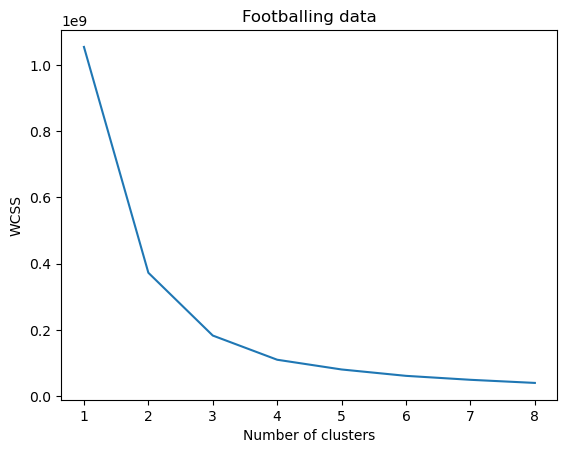

In [24]:
#this model finds the optimal value for K in the model
#for each number in the range 1-8, the number is implemented on the model
#inertia is the sum of squared distances between each sample in the dataset and its nearest centroid
#these values are appended to the list and implemented on a line graph
wcss=[]
for i in range(1,9):
    kmeans = KMeans(i)
    kmeans.fit(X)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

    number_clusters = range(1,9)
plt.plot(number_clusters,wcss)
plt.title('Footballing data')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [25]:
#standard scaler is defined and the features are converted to a dataframe, fitting the scaler on the feature values
scaler = StandardScaler()
df90_num[features] = pd.DataFrame(scaler.fit_transform(df90_num[features].values), columns=features, index=df90_num.index)

In [26]:
#setting up variables for hierachical agglomerative clustering for improvements on KMeans and for in-depth analysis
N_FEATURES = len(features)
N_CLUSTERS = 4
N_DIMENSIONS_TSNE = 2
N_INTERPRETABLE_DIMS = 4

In [27]:
#fits a dimensionality reduction technique (tSNE) on the data to explore the variables and for plotting the relationships
Xs_embedded = TSNE(n_components=N_DIMENSIONS_TSNE).fit_transform(X)

C:\Users\crmch\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\crmch\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


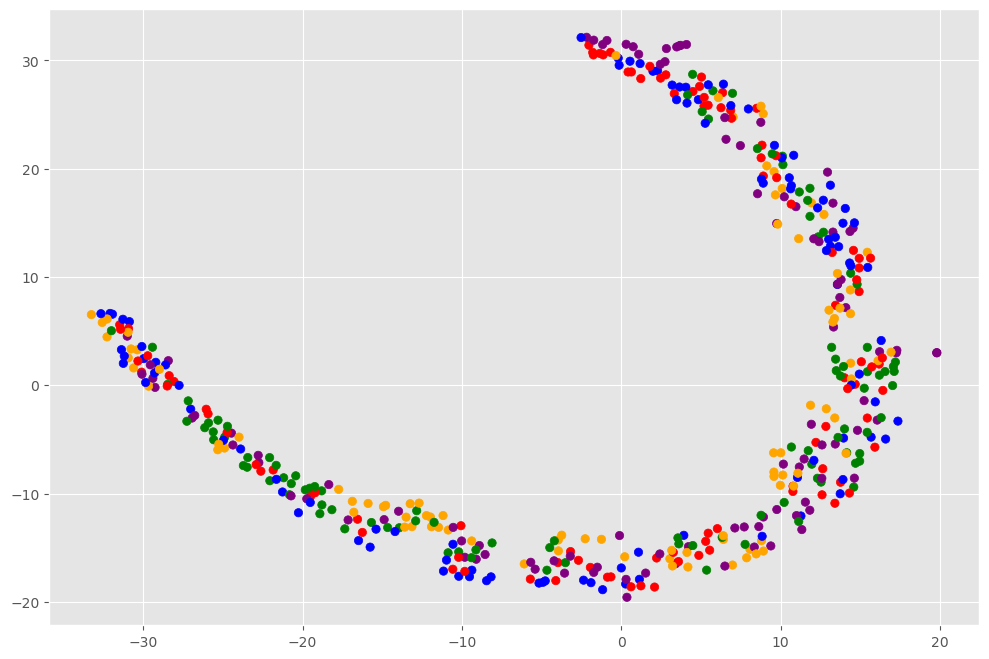

In [30]:
#plots a scatter with colours indicating the league, data points are based from the PCA
league = df90['League']
with plt.style.context('ggplot'):
    
    fig, ax = plt.subplots(figsize=(12,8))
    colors = league.map({'Premier League': 'Blue', 
                             'La Liga': 'Red', 
                             'Serie A': 'Green', 
                             'Ligue 1': 'Purple', 
                             'Bundesliga': 'Orange'})

    ax.scatter(x=Xs_embedded[:, 0], y=Xs_embedded[:, 1], c=colors)

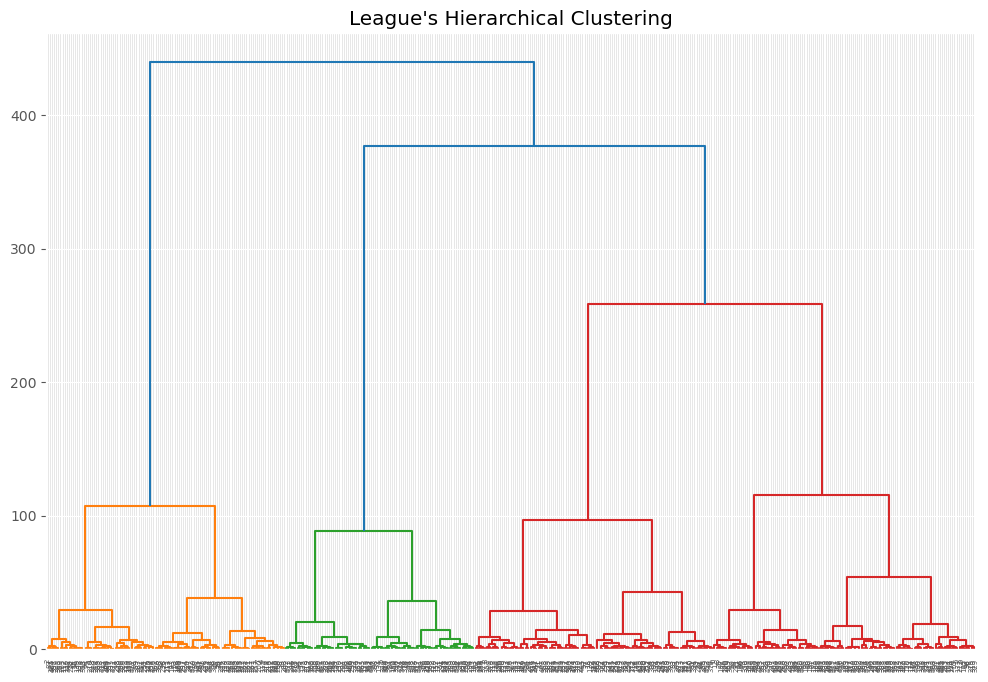

In [31]:
#dendrogram using the pca data points to show the clusterings of teams
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.title.set(text="League's Hierarchical Clustering")
    dend = shc.dendrogram(shc.linkage(Xs_embedded, method='ward'))

In [32]:
#makes use of agglomerative clustering model with 4 clusters
#labels are predicted based on the pca and assigned to a new column in the dataframe
model = AgglomerativeClustering(distance_threshold=None, n_clusters=N_CLUSTERS)
labels = model.fit_predict(Xs_embedded)
df90_num['label'] = labels
df90['label'] = df90_num['label']

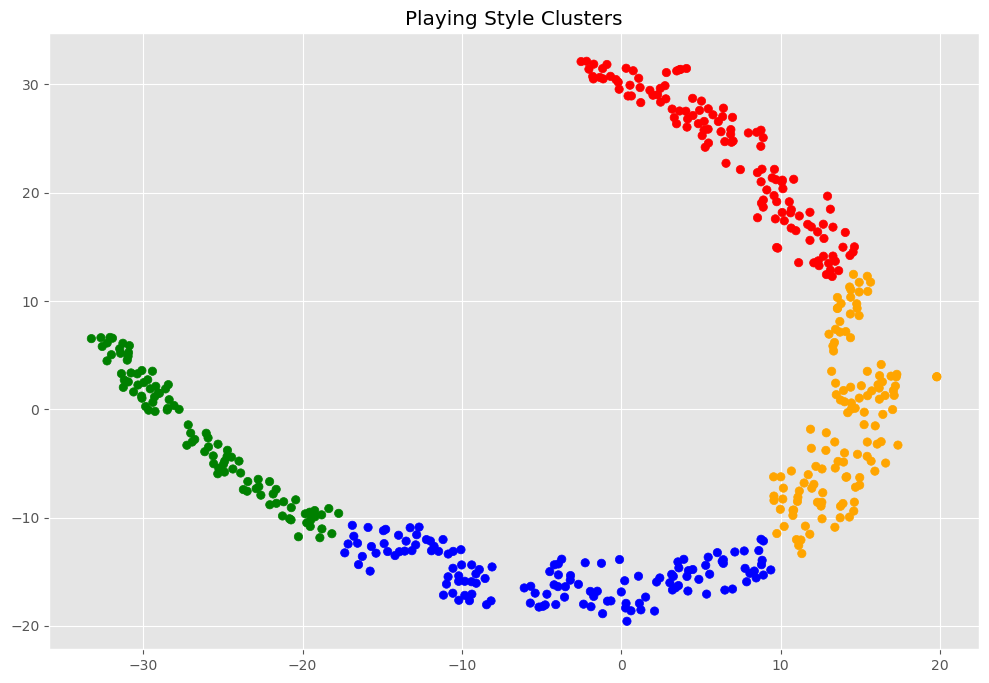

In [33]:
#set the label column to a variable to be called on the updated scatter plot using the pca data points
#colour is determined by the cluster
label = df90['label']
with plt.style.context('ggplot'):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.title.set(text="Playing Style Clusters")
    colors = label.map({0: 'Blue', 
                             1: 'Red', 
                             2: 'Green', 
                             3: 'Orange'})
    ax.scatter(x=Xs_embedded[:, 0], y=Xs_embedded[:, 1], c=colors, cmap='gist_ncar')

In [34]:
#factor analysis is computed on the original features and is fitted on to the data
fa = FactorAnalyzer(rotation='promax', n_factors = N_INTERPRETABLE_DIMS)

fa.fit(X)

fa_Xs = fa.fit_transform(X)

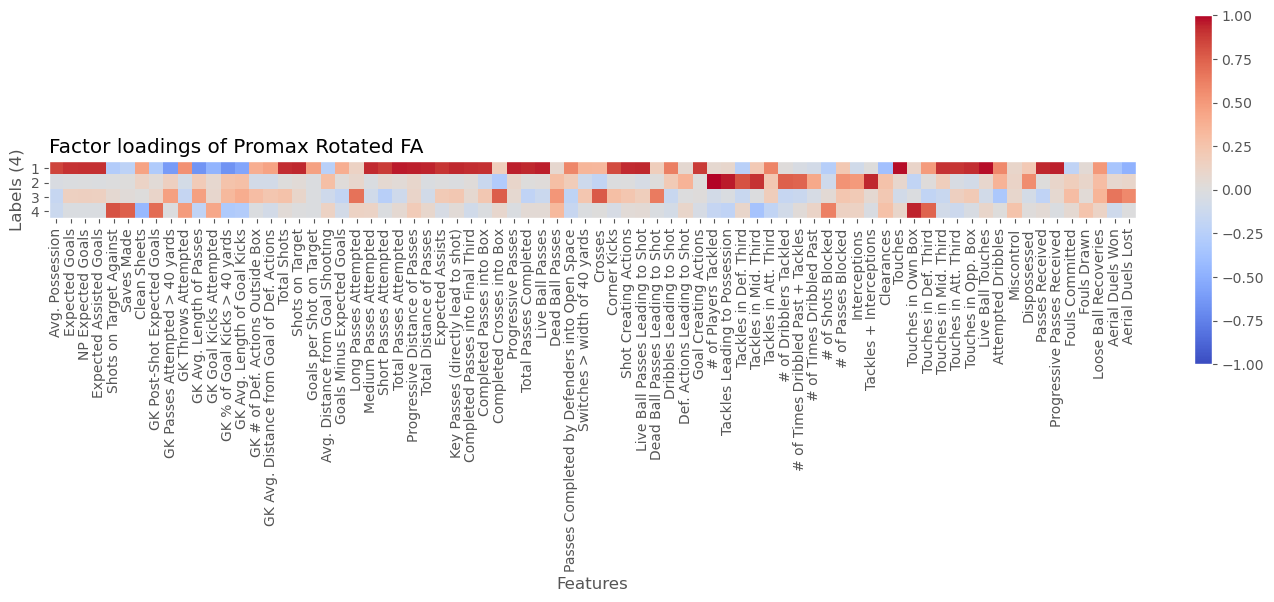

In [35]:
#a heatmap highlights relationships between variables and their cluster
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(fa.loadings_.T, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(N_FEATURES))
    ax.set_yticks(range(N_INTERPRETABLE_DIMS))
    ax.set_xticklabels(features, rotation=90)
    ax.set_yticklabels(range(1, N_INTERPRETABLE_DIMS + 1))
    plt.colorbar(im, fraction=0.015)
    ax.set(ylabel = f"Labels ({N_INTERPRETABLE_DIMS})", xlabel='Features')
    ax.grid(False)
    ax.title.set(text='Factor loadings of Promax Rotated FA', x=0, ha='left')

In [36]:
#data with the labels is saved to a new csv file
df90.to_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\FootballLabel1.csv')

In [37]:
#csv file is opened
df90Label = pd.read_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\FootballLabel1.csv')

In [42]:
#querying the data to show teams based in each cluster to determine which cluster is best
df90Label.query("label == 2")[['Squad', 'League']].head(10)

Squad          League
5           Chelsea 2021 - 2022  Premier League
10        Liverpool 2021 - 2022  Premier League
11  Manchester City 2021 - 2022  Premier League
23        Barcelona 2021 - 2022         La Liga
35      Real Madrid 2021 - 2022         La Liga
37          Sevilla 2021 - 2022         La Liga
44       Fiorentina 2021 - 2022         Serie A
47            Inter 2021 - 2022         Serie A
48         Juventus 2021 - 2022         Serie A
49            Lazio 2021 - 2022         Serie A

# Generative Adversarial Networks

## Preprocessing

In [2]:
#read in the csv file to a variable
df90Label = pd.read_csv(r'C:\Users\crmch\OneDrive\Desktop\College\Year 4\Semester 2\Project 2\Datasets\FootballLabel.csv')

In [3]:
squad = df90Label['Squad']
league = df90Label['League']

In [4]:
#drop categorical values
df90Label = df90Label.drop(['Squad', 'League'], axis = 1)

In [5]:
#split the data based on the best cluster and the best
real_data = df90Label[df90Label['label'] == 2]
synthetic_data = df90Label[df90Label['label'] != 2]

In [6]:
#drop the label column
synthetic_data = synthetic_data.drop(['label'], axis = 1)
real_data = real_data.drop(['label'], axis = 1)

## Train Test Splitting

In [48]:
#define X from the synthetic data for training and testing
#split the data into 80:20 ratio
#scale the data using standard scaler and convert this data back to a dataframe
input_var = list(synthetic_data.columns)
X = synthetic_data[input_var]

#split data into train and test with test size of .20
syn_train, syn_test = train_test_split(X, test_size=0.20)

scaler = StandardScaler()

syn_train = scaler.fit_transform(syn_train)

syn_train = pd.DataFrame(syn_train)

## Training the Model

In [49]:
#define the generator
def make_generator(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(output_dim, activation = 'linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

#define the discriminator
def make_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

#define the GAN
def make_gan(generator, discriminator):
    discriminator.trainable = False
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

#train the GAN
input_dim = real_data.shape[1]
output_dim = real_data.shape[1]

generator = make_generator(input_dim, output_dim)
discriminator = make_discriminator(input_dim)
gan = make_gan(generator, discriminator)

batch_size = 100
epochs = 1000

for epoch in range(epochs):
    #get a batch of synthetic data
    idx = np.random.randint(0, syn_train.shape[0], size=batch_size)
    syn_train_data = syn_train.iloc[idx]
    
    #get a batch of real data
    idx = np.random.randint(0, real_data.shape[0], size=batch_size)
    acc_data = real_data.iloc[idx]
    
    #train the discriminator
    discriminator.trainable = True
    y_real = np.ones((batch_size,))
    y_fake = np.zeros((batch_size,))
    discriminator.train_on_batch(acc_data, y_real)
    discriminator.train_on_batch(syn_train_data, y_fake)
    
    #train the generator
    idx = np.random.randint(0, syn_train.shape[0], size=batch_size)
    y = syn_train.iloc[idx]
    discriminator.trainable = False
    gan.train_on_batch(y, np.ones(batch_size))

## Testing the Model

In [79]:
#evaluate the GAN on the test set
#use the same standard scaler to scale the testing data
syn_check = scaler.transform(syn_test)
syn_test_df = pd.DataFrame(syn_check)

#conver the testing data into tensors and generate new data from the tensors
tf_check = tf.convert_to_tensor(syn_test_df)
generate_data = generator.predict(tf_check)

#inverse the scaling of the tensors and put back into a dataframe and show the results
inverse = scaler.inverse_transform(generate_data)
syn_df = pd.DataFrame(inverse, columns=real_data.columns)

syn_df

3/3 [==============================] - 0s 5ms/step


Avg. Possession  Expected Goals  NP Expected Goals  \
0         52.663132        1.234234           1.102857   
1         51.521366        1.155430           1.261445   
2         50.832790        1.239976           1.113525   
3         53.657280        1.224539           1.032621   
4         51.876236        1.193282           1.148683   
..              ...             ...                ...   
76        51.794044        1.255709           1.092700   
77        53.957535        1.256677           1.002845   
78        52.996403        1.304859           1.098027   
79        51.912800        1.217119           1.168133   
80        51.282310        1.237533           1.139390   

    Expected Assisted Goals  Shots on Target Against  Saves Made  \
0                  0.813302                 4.239382    3.049354   
1                  0.708827                 4.156295    2.975211   
2                  0.722356                 4.424398    3.295621   
3                  0.755377                 4.239151    3.266535   
4                  0.725721                 4.463048    3.100141   
..                      ...                      ...         ...   
76                 0.796941                 4.340099    3.148747   
77                 0.757984                 4.245981    3.203327   
78                 0.664492                 4.281952    3.273656   
79                 0.731839                 4.197191    3.233396   
80                 0.767429                 4.239892    3.283824   

    Clean Sheets  GK Post-Shot Expected Goals  GK Passes Attempted > 40 yards  \
0       0.216155                     1.193923                       13.122287   
1       0.217244                     1.124000                       13.626398   
2       0.252278                     1.124199                       14.136736   
3       0.256722                     1.123991                       12.155275   
4       0.258313                     1.106364                       13.637352   
..           ...                          ...                             ...   
76      0.249460                     1.139700                       13.677293   
77      0.245943                     1.122564                       13.835550   
78      0.254487                     1.177297                       12.994491   
79      0.255631                     1.198532                       14.356011   
80      0.247512                     1.170691                       14.625461   

    GK Throws Attempted  ...  Attempted Dribbles  Miscontrol  Dispossessed  \
0              5.399804  ...           16.623505   12.829991      7.011839   
1              5.813047  ...           16.366602   13.036490      6.975214   
2              5.676617  ...           16.700413   12.870332      7.564575   
3              5.885312  ...           15.649961   12.224875      6.995530   
4              5.594884  ...           16.061687   12.895628      6.667999   
..                  ...  ...                 ...         ...           ...   
76             5.790385  ...           15.949141   12.600847      7.422318   
77             5.577280  ...           16.299135   13.026824      7.124039   
78             5.542144  ...           16.308462   12.921210      6.828465   
79             5.539386  ...           16.402821   13.611210      7.700078   
80             5.446953  ...           16.074110   13.353680      7.792871   

    Passes Received  Progressive Passes Received  Fouls Committed  \
0        351.019409                    27.254837        13.077699   
1        352.297058                    27.173565        12.719483   
2        355.135498                    26.905132        12.771363   
3        338.772797                    26.369614        13.349868   
4        366.188385                    26.958687        12.568443   
..              ...                          ...              ...   
76       366.476440                    28.013531        12.712641   
77       341.513031         

In [85]:
#the original testing data
syn_test

Avg. Possession  Expected Goals  NP Expected Goals  \
77              48.5        1.171053           1.071053   
191             44.7        0.844118           0.773529   
116             43.2        1.457895           1.371053   
403             54.7        1.465789           1.402632   
186             46.3        1.191176           1.055882   
..               ...             ...                ...   
24              53.7        1.552632           1.428947   
36              54.3        1.523684           1.318421   
488             47.4        1.144118           1.144118   
184             49.6        1.232353           1.094118   
143             46.3        1.181579           1.057895   

     Expected Assisted Goals  Shots on Target Against  Saves Made  \
77                  0.815789                 4.973684    3.052632   
191                 0.605882                 6.882353    4.470588   
116                 1.042105                 3.868421    2.710526   
403                 1.065789                 3.763158    3.078947   
186                 0.750000                 4.647059    2.852941   
..                       ...                      ...         ...   
24                  1.113158                 3.473684    2.473684   
36                  0.997368                 3.342105    2.342105   
488                 0.929412                 4.764706    3.617647   
184                 0.855882                 4.147059    2.617647   
143                 0.831579                 4.000000    2.421053   

     Clean Sheets  GK Post-Shot Expected Goals  \
77       0.105263                     1.805263   
191      0.117647                     2.052941   
116      0.289474                     1.105263   
403      0.500000                     1.036842   
186      0.147059                     1.614706   
..            ...                          ...   
24       0.342105                     1.028947   
36       0.526316                     0.934211   
488      0.235294                     1.235294   
184      0.264706                     1.379412   
143      0.236842                     1.560526   

     GK Passes Attempted > 40 yards  GK Throws Attempted  ...  \
77                        14.342105             5.868421  ...   
191                       14.705882             5.705882  ...   
116                       17.052632             4.184211  ...   
403                       16.500000             4.000000  ...   
186                       15.911765             3.647059  ...   
..                              ...                  ...  ...   
24                        14.394737             4.131579  ...   
36                        13.710526             3.657895  ...   
488                       16.941176             5.441176  ...   
184                       12.617647             4.558824  ...   
143                       14.789474             4.473684  ...   

     Attempted Dribbles  Miscontrol  Dispossessed  Passes Received  \
77            19.421053   19.078947     10.421053       360.184211   
191           18.147059   17.411765     10.352941       321.764706   
116           14.263158   12.921053      8.368421       329.894737   
403           19.368421   13.473684     10.500000       462.631579   
186           12.352941   16.941176      7.764706       345.735294   
..                  ...         ...           ...              ...   
24            17.236842   15.473684      9.578947       407.236842   
36            17.631579   16.473684     10.289474       397.447368   
488           14.029412    9.323529     10.029412       348.617647   
184           16.794118   16.558824      9.117647       364.529412   
143           15.131579   14.763158     11.105263       348.973684   

     Progressive Passes Received  Fouls Committed  Fouls Drawn  \
77                     25.526316        12.210526    11.605263   
191                    20.588235        12.205882    11.852941   
116                    21.868421         9.868

## Plotting the Data

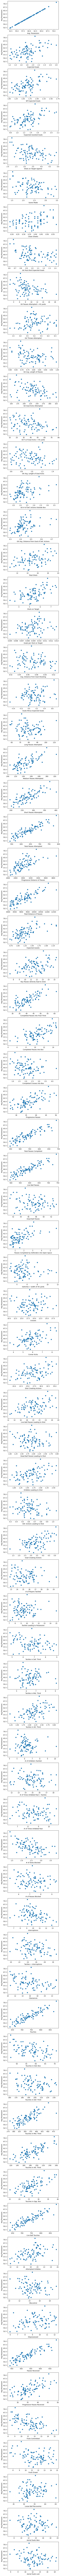

In [53]:
#plot scatterplots for original data
fig, axs = plt.subplots(nrows=len(real_data.columns), ncols=1, figsize=(6, 4*len(real_data.columns)))
for i, col in enumerate(real_data.columns):
    axs[i].scatter(real_data[col], real_data['Avg. Possession'])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Avg.Possession')
    
plt.show()

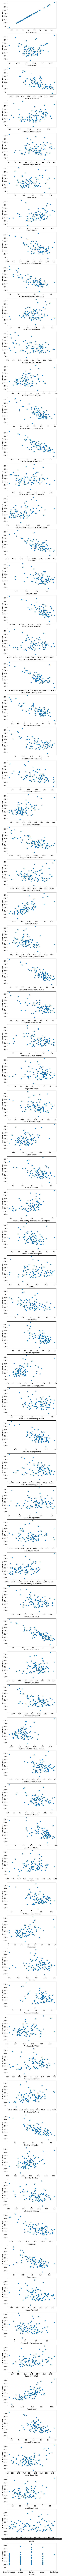

In [54]:
#plot scatterplots for synthetic data
fig, axs = plt.subplots(nrows=len(syn_df.columns), ncols=1, figsize=(6, 4*len(syn_df.columns)))
for i, col in enumerate(syn_df.columns):
    axs[i].scatter(syn_df[col], syn_df['Avg. Possession'])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Avg. Possession')
    
plt.show()

## Saving the Model

In [374]:
#open a new pickle file and save the generator and the scaler
with open('generator.pkl', 'wb') as file:
    pickle.dump({'generator': generator, 'scaler': scaler}, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\leaky_re_lu
......vars
...layers\leaky_re_lu_1
......vars
...layers\leaky_re_lu_2
......vars
...optimizer
......vars
.........0
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-07 00:32:27         2659
metadata.json                                  2023-05-07 00:32:27           64
variables.h5                                   2023-05-07 00:32:27      3039200


In [7]:
#open the pickle file
generator_loaded = pickle.load(open('generator.pkl', 'rb'))

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-05-07 00:32:26         2659
metadata.json                                  2023-05-07 00:32:26           64
variables.h5                                   2023-05-07 00:32:26      3039200
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\leaky_re_lu
......vars
...layers\leaky_re_lu_1
......vars
...layers\leaky_re_lu_2
......vars
...optimizer
......vars
.........0
...vars


In [8]:
#set the generator and the scaler to variables
generator = generator_loaded['generator']
scaler = generator_loaded['scaler']

## Validating the Saved Model

In [9]:
#open the portugal csv file for validation
port = pd.read_csv('C:/Users/crmch/OneDrive/Desktop/College/Year 4/Semester 2/Project 2/Datasets/portugalFinal.csv', sep = ',')

In [10]:
#assign a team's data to the variable
val = port[port['Squad'] == 'Vitória 2021 - 2022']

In [54]:
val

Squad  Avg. Possession  Expected Goals  NP Expected Goals  \
16  Vitória 2021 - 2022             48.7            1.45           1.258824   

    Expected Assisted Goals  Shots on Target Against  Saves Made  \
16                 0.932353                 4.235294         3.0   

    Clean Sheets  GK Post-Shot Expected Goals  GK Passes Attempted > 40 yards  \
16      0.235294                     1.391176                       15.323529   

    ...  Miscontrol  Dispossessed  Passes Received  \
16  ...   15.294118      7.617647       336.882353   

    Progressive Passes Received  Fouls Committed  Fouls Drawn  \
16                         37.0        16.264706    13.441176   

    Loose Ball Recoveries  Aerial Duels Won  Aerial Duels Lost         League  
16              47.911765         14.411765          14.794118  Primeira Liga  

[1 rows x 78 columns]

In [11]:
#drop the categorical values
val = port.drop(['Squad', 'League'], axis = 1)

In [12]:
#scale the validation data using the scaler from the training data
import tensorflow as tf
val_check = scaler.transform(val)
syn_val_df = pd.DataFrame(val_check)

#convert this data to tensors
tf_val = tf.convert_to_tensor(syn_val_df)

#generate synthetic data using the generator model
synthetic_data_scaled = generator.predict(tf_val)

#inverse the scaling to get the unscaled synthetic data and convert to dataframe to show the results
inver = scaler.inverse_transform(synthetic_data_scaled)
val_df = pd.DataFrame(inver, columns=val.columns)

val_df

1/1 [==============================] - 0s 112ms/step


Avg. Possession  Expected Goals  NP Expected Goals  \
0         54.622379        1.268904           1.075208   
1         53.165161        1.254918           1.155896   
2         58.800922        1.189800           0.930093   
3         54.539650        1.294499           1.095025   
4         54.278500        1.208680           1.084233   
5         52.111168        1.214612           1.120922   
6         53.513493        1.299979           1.002215   
7         54.979401        1.242507           1.101412   
8         53.176682        1.213340           1.066949   
9         54.279907        1.302313           1.042109   
10        53.446026        1.258366           1.143251   
11        52.645409        1.238566           1.109623   
12        60.182148        1.211007           0.905105   
13        52.696758        1.263328           1.090762   
14        57.824970        1.170308           0.965471   
15        53.907753        1.235561           1.134269   
16        54.760815        1.304663           1.052953   
17        53.883667        1.252631           1.029685   

    Expected Assisted Goals  Shots on Target Against  Saves Made  \
0                  0.654569                 4.359176    3.188560   
1                  0.584121                 4.276718    3.393510   
2                  0.676013                 3.996649    3.406079   
3                  0.604153                 4.240117    3.153199   
4                  0.680128                 4.094293    3.333042   
5                  0.599190                 4.208147    3.433483   
6                  0.681515                 4.387592    3.150326   
7                  0.639127                 3.857426    3.290518   
8                  0.614913                 4.189803    3.166088   
9                  0.615819                 4.235818    3.250181   
10                 0.606644                 4.282343    3.361469   
11                 0.594049                 4.246020    3.317920   
12                 0.623414                 4.247883    3.336994   
13                 0.649066                 4.419295    3.211877   
14                 0.710322                 4.351333    3.414444   
15                 0.623780                 4.234126    3.087786   
16                 0.684995                 4.049947    3.286388   
17                 0.619278                 4.642107    3.416776   

    Clean Sheets  GK Post-Shot Expected Goals  GK Passes Attempted > 40 yards  \
0       0.228720                     1.207583                       13.680129   
1       0.223048                     1.154927                       13.613987   
2       0.257371                     1.006615                        9.433392   
3       0.218608                     1.227460                       13.628087   
4       0.231389                     1.183658                       13.080577   
5       0.222307                     1.202375                       14.273701   
6       0.242005                     1.250338                       13.073945   
7       0.227261                     1.214863                       13.760110   
8       0.224999                     1.239058                       13.223795   
9       0.204215                     1.195511                       13.429834   
10      0.231348                     1.197029                       13.182337   
11      0.229878                     1.237094                       14.819776   
12      0.253075                     0.834540                        9.990691   
13      0.231877                     1.222552                       13.660163   
14      0.242171                     1.077354                       10.665926   
15      0.238169                     1.168537                       13.584329   
16      0.217078                     1.205744                       13.341944   
17      0.235421                     1.127309                       12.628717   

    GK Throws Attempted  ...  Attempted Dribbles  Miscontrol  Dispos

In [13]:
desc_r = real_data.describe()

In [14]:
desc = val_df.describe()

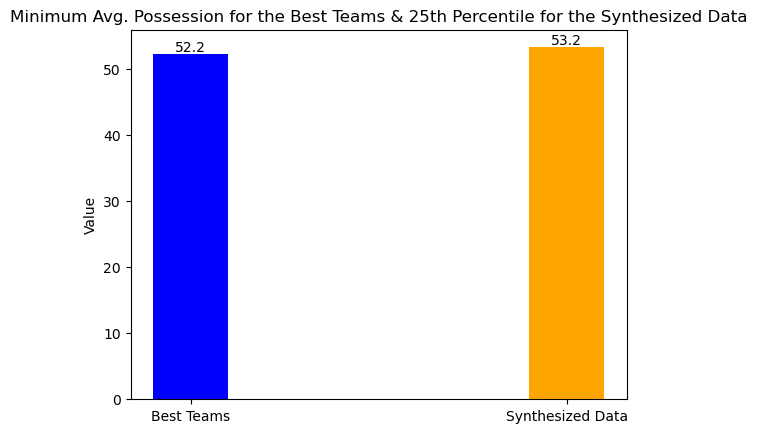

In [17]:
#set the data columns names
real_data_name = 'Best Teams'
synthesised_data_name = 'Synthesized Data'

real_data_values = desc_r['Avg. Possession'].iloc[3:4][0]
synthesised_data_values = desc['Avg. Possession'].iloc[4:5][0]

#create a list of labels
labels = [real_data_name, synthesised_data_name]

#combine the data into a single list
combined_data = [real_data_values, synthesised_data_values]
#swap the axes and plot the histogram
plt.bar(labels, combined_data, color=['blue', 'orange'], width = 0.2)

#add labels and title
plt.ylabel('Value')
plt.title('Minimum Avg. Possession for the Best Teams & 25th Percentile for the Synthesized Data')

for i, v in enumerate(combined_data):
    plt.text(i, v, '{:.1f}'.format(v), ha='center', va='bottom')

# Displaying the plot
plt.show()

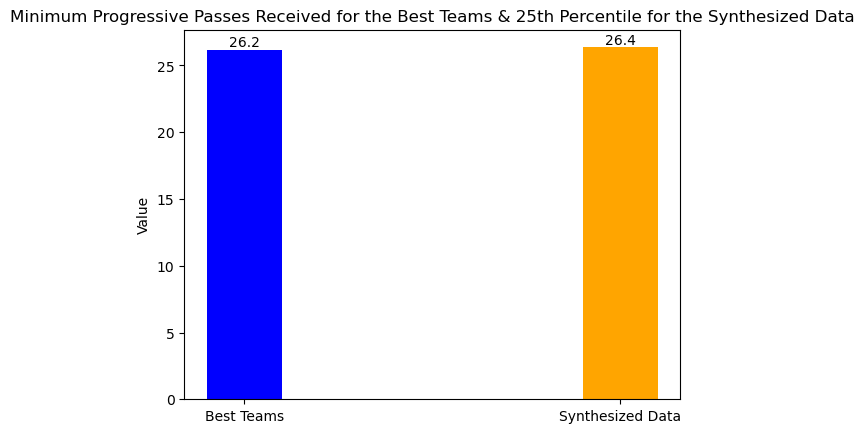

In [18]:
#set the data columns names
real_data_name = 'Best Teams'
synthesised_data_name = 'Synthesized Data'

real_data_values = desc_r['Progressive Passes Received'].iloc[3:4][0]
synthesised_data_values = desc['Progressive Passes Received'].iloc[4:5][0]

#create a list of labels
labels = [real_data_name, synthesised_data_name]

#combine the data into a single list
combined_data = [real_data_values, synthesised_data_values]
#swap the axes and plot the histogram
plt.bar(labels, combined_data, color=['blue', 'orange'], width = 0.2)

#add labels and title
plt.ylabel('Value')
plt.title('Minimum Progressive Passes Received for the Best Teams & 25th Percentile for the Synthesized Data')

for i, v in enumerate(combined_data):
    plt.text(i, v, '{:.1f}'.format(v), ha='center', va='bottom')

# Displaying the plot
plt.show()

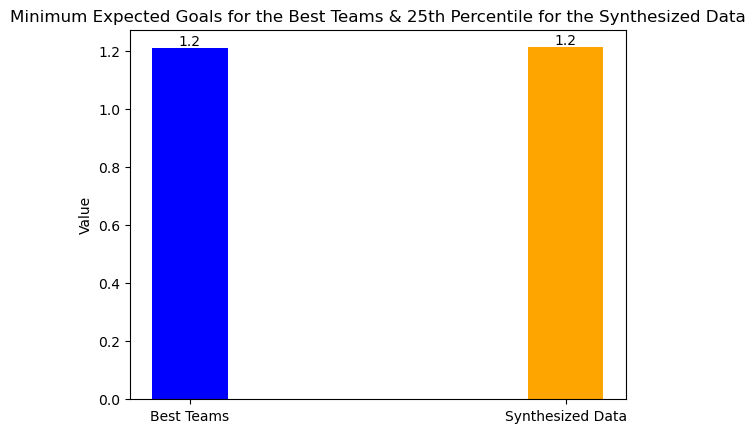

In [19]:
#set the data columns names
real_data_name = 'Best Teams'
synthesised_data_name = 'Synthesized Data'

real_data_values = desc_r['Expected Goals'].iloc[3:4][0]
synthesised_data_values = desc['Expected Goals'].iloc[4:5][0]

#create a list of labels
labels = [real_data_name, synthesised_data_name]

#combine the data into a single list
combined_data = [real_data_values, synthesised_data_values]
#swap the axes and plot the histogram
plt.bar(labels, combined_data, color=['blue', 'orange'], width = 0.2)

#add labels and title
plt.ylabel('Value')
plt.title('Minimum Expected Goals for the Best Teams & 25th Percentile for the Synthesized Data')

for i, v in enumerate(combined_data):
    plt.text(i, v, '{:.1f}'.format(v), ha='center', va='bottom')

# Displaying the plot
plt.show()

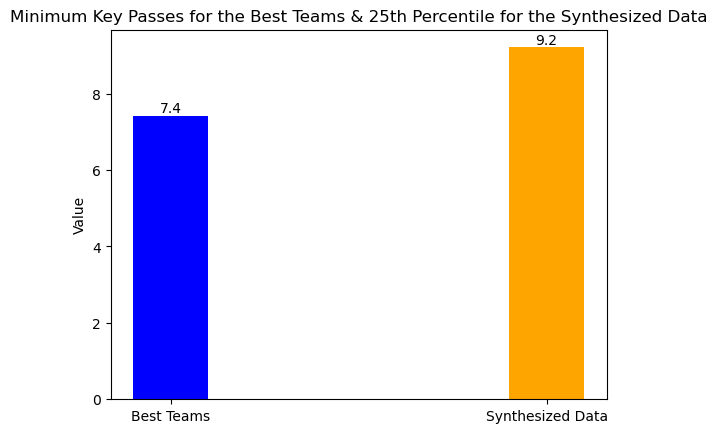

In [20]:
#set the data columns names
real_data_name = 'Best Teams'
synthesised_data_name = 'Synthesized Data'

real_data_values = desc_r['Key Passes (directly lead to shot)'].iloc[3:4][0]
synthesised_data_values = desc['Key Passes (directly lead to shot)'].iloc[4:5][0]

#create a list of labels
labels = [real_data_name, synthesised_data_name]

#combine the data into a single list
combined_data = [real_data_values, synthesised_data_values]
#swap the axes and plot the histogram
plt.bar(labels, combined_data, color=['blue', 'orange'], width = 0.2)

#add labels and title
plt.ylabel('Value')
plt.title('Minimum Key Passes for the Best Teams & 25th Percentile for the Synthesized Data')

for i, v in enumerate(combined_data):
    plt.text(i, v, '{:.1f}'.format(v), ha='center', va='bottom')

# Displaying the plot
plt.show()

In [ ]:
!streamlit run dashboardingFootball.py

# Self Organizing Maps

In [75]:
#define the scaler
scaler = MinMaxScaler()

#define the euclidean distance
def e_distance(x,y):
    return distance.euclidean(x,y)

#define the manhattan distance
def m_distance(x,y):
    return distance.cityblock(x,y)

#define the best matching unit search
def winning_neuron(data, t, som, num_rows, num_cols):
    winner = [0,0]
    shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
    input_data = data[t]
    for row in range(num_rows):
        for col in range(num_cols):
            distance = e_distance(som[row][col], data[t])
            if distance < shortest_distance: 
                shortest_distance = distance
                winner = [row,col]
    return winner

#define the calculation for the learning rate and neighbourhood range
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
    coefficient = 1.0 - (np.float64(step)/max_steps)
    learning_rate = coefficient*max_learning_rate
    neighbourhood_range = ceil(coefficient * max_m_dsitance)
    return learning_rate, neighbourhood_range

In [81]:
#assign the hyperparameters to variables
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

In [77]:
#scale the data
train_x_norm = scaler.fit_transform(train_x)

#initialising self-organising map and construct the map
num_dims = train_x_norm.shape[1]
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims))

#start training iterations through the for loop
for step in range(max_steps):
    if (step+1) % 1000 == 0:
        print("Iteration: ", step+1)
    learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

    #take a random index of training data
    t = np.random.randint(0,high=train_x_norm.shape[0])
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    for row in range(num_rows):
        for col in range(num_cols):
            if m_distance([row,col],winner) <= neighbourhood_range:
                #update the neighbours weight
                som[row][col] += learning_rate*(train_x_norm[t]-som[row][col])

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [83]:
#collect the labels
label_data = train_y
myMap = np.empty(shape=(num_rows, num_cols), dtype=object)

# define an empty list to store the labels
for row in range(num_rows):
    for col in range(num_cols):
        myMap[row][col] = []

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    print(winner)

[0, 6]
[2, 6]
[8, 9]
[6, 9]
[1, 2]
[7, 3]
[6, 9]
[0, 6]
[1, 5]
[4, 1]
[0, 4]
[5, 5]
[8, 1]
[4, 1]
[2, 6]
[2, 7]
[6, 7]
[6, 0]
[2, 5]
[6, 2]
[8, 7]
[9, 6]
[3, 5]
[4, 7]
[6, 9]
[4, 5]
[3, 4]
[9, 2]
[4, 4]
[7, 8]
[5, 2]
[0, 9]
[5, 7]
[6, 9]
[8, 2]
[3, 2]
[6, 7]
[8, 5]
[1, 7]
[2, 9]
[6, 9]
[0, 1]
[3, 0]
[2, 8]
[5, 7]
[9, 6]
[3, 8]
[4, 1]
[5, 9]
[3, 8]
[7, 2]
[9, 0]
[5, 5]
[6, 7]
[8, 5]
[3, 5]
[3, 4]
[0, 4]
[4, 3]
[4, 6]
[4, 6]
[5, 6]
[0, 3]
[0, 2]
[4, 3]
[1, 6]
[6, 9]
[4, 3]
[9, 9]
[1, 5]
[6, 9]
[0, 7]
[3, 0]
[6, 5]
[6, 4]
[2, 7]
[8, 9]
[4, 9]
[1, 7]
[6, 1]
[8, 5]
[5, 3]
[8, 7]
[0, 0]
[3, 6]
[0, 2]
[3, 2]
[2, 4]
[1, 1]
[5, 0]
[2, 3]
[0, 4]
[4, 5]
[7, 6]
[5, 2]
[2, 0]
[4, 1]
[5, 1]
[8, 3]
[7, 0]
[0, 0]
[7, 8]
[7, 8]
[5, 0]
[0, 1]
[6, 4]
[3, 8]
[1, 2]
[3, 0]
[6, 2]
[7, 0]
[5, 9]
[1, 9]
[6, 7]
[2, 6]
[1, 0]
[2, 2]
[7, 0]
[5, 5]
[1, 5]
[2, 7]
[9, 0]
[4, 9]
[8, 2]
[8, 1]
[7, 6]
[2, 3]
[7, 8]
[5, 9]
[2, 3]
[1, 0]
[9, 3]
[9, 0]
[9, 4]
[3, 0]
[5, 8]
[0, 8]
[1, 1]
[3, 7]
[0, 9]
[2, 3]
[0, 7]
[7, 4]

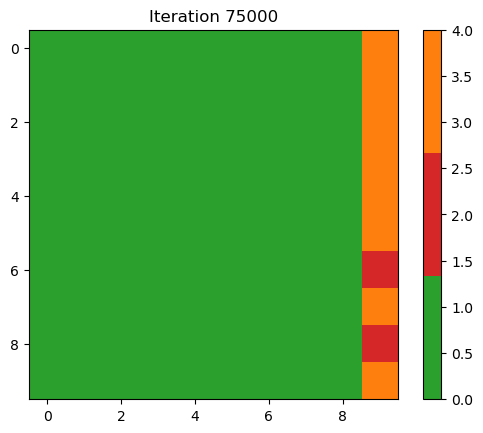

In [79]:
#construct the label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
    if len(label_list)==0:
        label = 4
    else:
        label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [80]:
#scale the testing data using the scaler fitted on the training data
data = scaler.transform(test_x)

winner_labels = []

#using the trained som, search the winning node of corresponding to the test data
#get the label of the winning node
for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print('Accuracy: ', accuracy_score(test_y, np.array(winner_labels)))

Accuracy:  0.25510204081632654
